In [28]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)

source("../../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

# BOOTSTRAPING FOR FEATURE IMPORTANCE

In [29]:
df_bootstrap <- NULL
for (l in list.files('../InitialPrognosis/comparison_dataframes/')){
    if (grepl("_bootstrap",l)){
        if(grepl("_bootstrap_SVM",l)){
            df_tmp <- read.table(paste('../InitialPrognosis/comparison_dataframes/',l,sep=""),sep=',',header=T)
            df_tmp <- df_tmp[,-1]
            df_tmp <- df_tmp[,c(2,1,3)]
        } else {
            df_tmp <- read.table(paste('../InitialPrognosis/comparison_dataframes/',l,sep=""))
        }
        colnames(df_tmp) <- c("feature","sum_coef","num_selected")
        df_tmp$model_algo <- str_sub(l, 1, str_length(l)-4)
        df_bootstrap <- rbind(df_bootstrap,df_tmp)   
    }
}
dim(df_bootstrap)
#df_bootstrap[df_bootstrap$feature=="age",]

[1] 27298     4

# II FOR AGE )
# II.1)Get Proportion of overall models and algorithms variable importance

In [32]:
# Count number of times each variable can appear in a model .
count_eln <- 14
count_clin <- 14
count_gen <- 14
count_cyto <- 14
count_comp <- 14
count_gender <- 14
count_age <-7
for (l in list.files('../InitialPrognosis/comparison_dataframes/')){
    if (grepl("eln",l) & !grepl("reduced",l) ){
        count_eln <-count_eln+1
    }
    if (grepl("clin",l) & !grepl("reduced",l) ){
        count_clin <-count_clin+1
    }
    if (grepl("gen",l) & !grepl("reduced",l) ){
        count_gen <-count_gen+1
    }
    if (grepl("cyto",l) & !grepl("reduced",l) ){
        count_cyto <-count_cyto+1
    }
    if (grepl("comp",l) & !grepl("reduced",l) ){
        count_comp <-count_comp+1
    }
    if (grepl("demo",l) & !grepl("reduced",l) ){
        count_gender <-count_gender+1
    }
    if ((grepl("demo",l) | grepl("gen_age",l))  & !grepl("reduced",l) & !grepl("without_age",l)){
        count_age <-count_age+1
    }
    }

#Same count but for glm models for coeff interpretation


df_final <- read.table("../InitialPrognosis/prognosis_comp_final.tsv")
genes <- colnames(df_final)[2:85]
cyto <- colnames(df_final)[86:154]
clin <- colnames(df_final)[155:161]
comp <- colnames(df_final)[164:180]

all <- df_bootstrap[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
all$proportion_selected <- ifelse(is.element(all$feature , genes),all$num_selected/count_gen,
                                 ifelse(is.element(all$feature,cyto),all$num_selected/count_cyto,
                                       ifelse(is.element(all$feature,clin),all$num_selected/count_clin,
                                             ifelse(is.element(all$feature,comp),all$num_selected/count_comp,
                                                   ifelse(all$feature=="eln_2017_ratio",all$num_selected/count_eln,
                                                       ifelse(all$feature=="gender",all$num_selected/count_gender,
                                                             ifelse(all$feature=="age",all$num_selected/count_age,0)))))))



Warning message:
“Factor `feature` contains implicit NA, consider using `forcats::fct_explicit_na`”

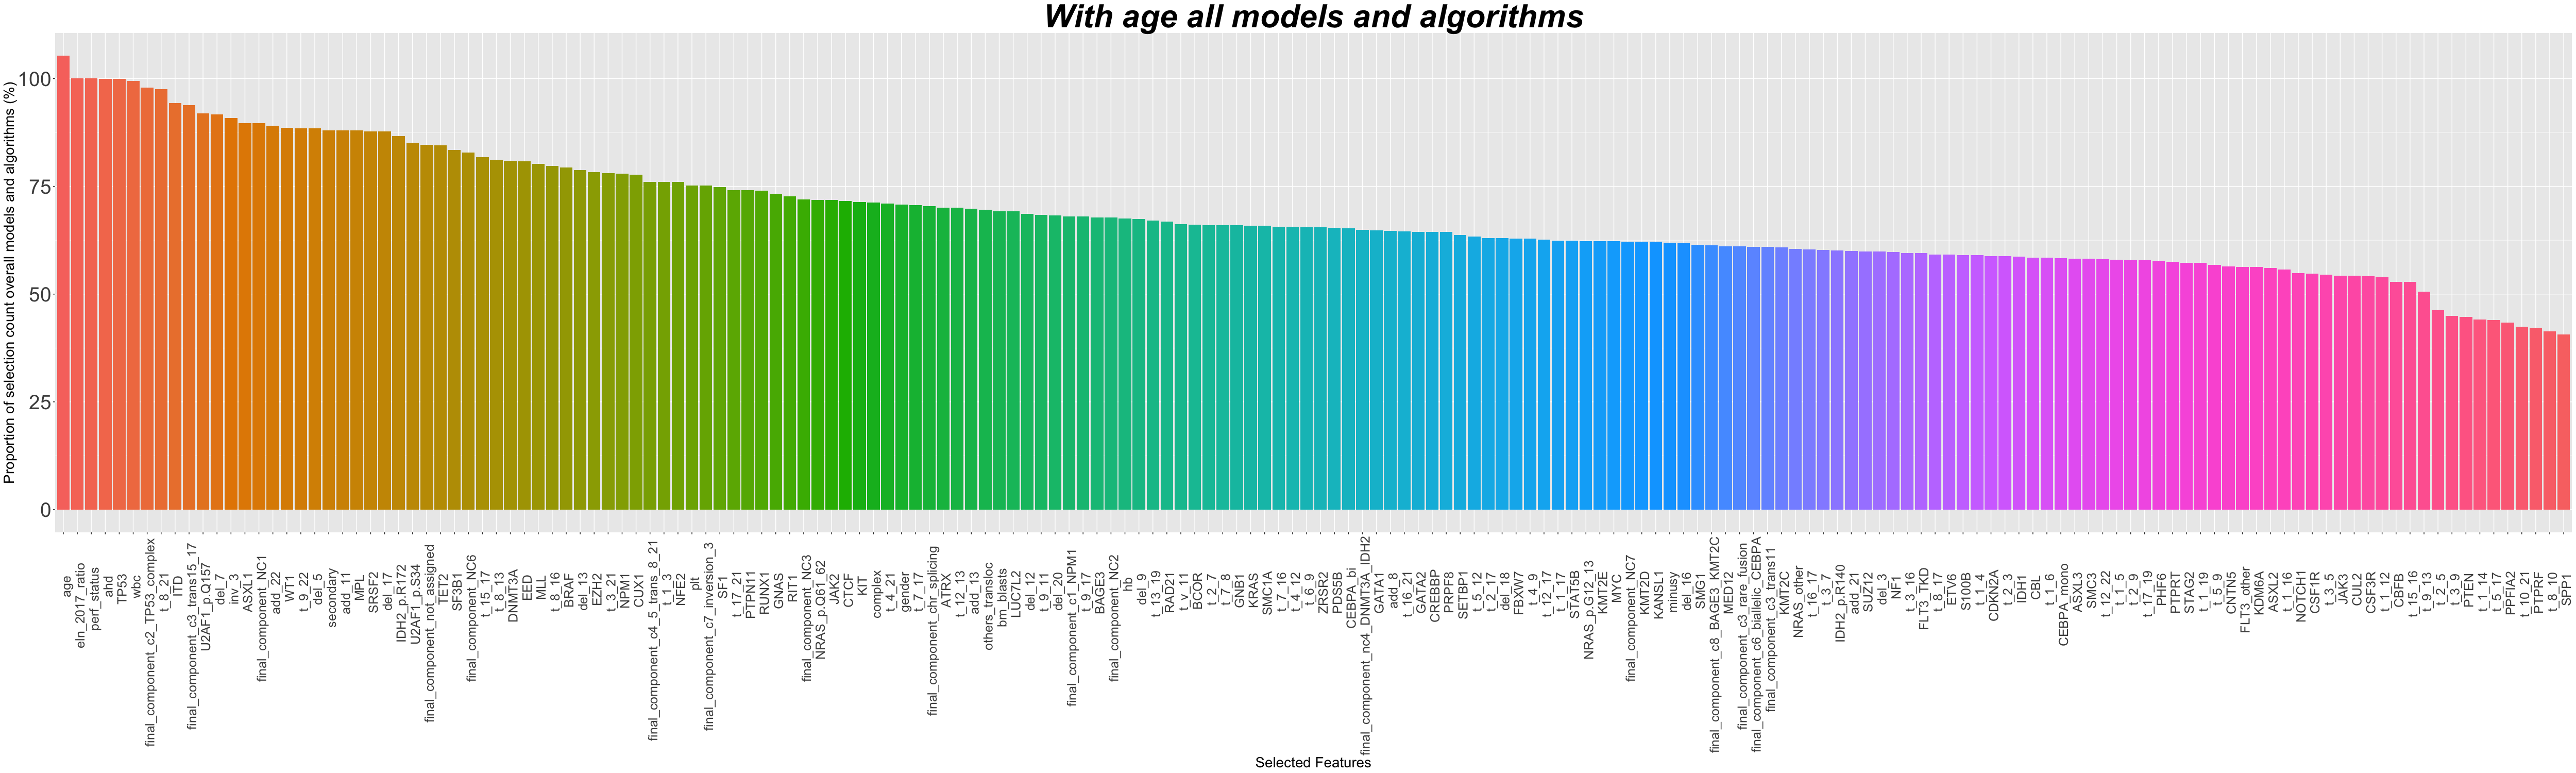

In [33]:
set_notebook_plot_size(50,15)
ggplot(na.omit(all),aes(x=reorder(feature,-proportion_selected),y=proportion_selected))+geom_bar(stat = "identity", aes(fill = reorder(feature,-proportion_selected)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Proportion of selection count overall models and algorithms (%)") + ggtitle("With age all models and algorithms")



# II.2)PROPORTION + COEFFICIENTS OVER ALL MODELS FOR GLM ALGORITHMS

In [34]:
count_eln_glm <- 6
count_clin_glm <- 6
count_gen_glm <- 6
count_cyto_glm <- 6
count_comp_glm <- 6
count_gender_glm <- 6
count_age_glm <-3
for (l in list.files('../InitialPrognosis/comparison_dataframes/')){
    if (grepl("eln",l) & grepl("glm",l) & !grepl("reduced",l) ){
        count_eln_glm <-count_eln_glm+1
    }
    if (grepl("clin",l) & grepl("glm",l) & !grepl("reduced",l) ){
        count_clin_glm <-count_clin_glm+1
    }
    if (grepl("gen",l) & grepl("glm",l) & !grepl("reduced",l) ){
        count_gen_glm <-count_gen_glm+1
    }
    if (grepl("cyto",l) & grepl("glm",l) & !grepl("reduced",l) ){
        count_cyto_glm <-count_cyto_glm+1
    }
    if (grepl("comp",l) & grepl("glm",l) & !grepl("reduced",l) ){
        count_comp_glm <-count_comp_glm+1
    }
    if (grepl("demo",l)  & grepl("glm",l) & !grepl("reduced",l) ){
        count_gender_glm <-count_gender_glm+1
    }
    if ((grepl("demo",l) | grepl("gen_age",l)) & grepl("glm",l)  & !grepl("reduced",l) & !grepl("without_age",l)){
        count_age_glm <-count_age_glm+1
    }
    }

all_glm <- df_bootstrap[grepl("glm",df_bootstrap$model_algo),]
all_glm <- all_glm[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
all_glm$proportion_selected <- ifelse(is.element(all_glm$feature , genes),all_glm$num_selected/count_gen_glm,
                                 ifelse(is.element(all_glm$feature,cyto),all_glm$num_selected/count_cyto_glm,
                                       ifelse(is.element(all_glm$feature,clin),all_glm$num_selected/count_clin_glm,
                                             ifelse(is.element(all_glm$feature,comp),all_glm$num_selected/count_comp_glm,
                                                   ifelse(all_glm$feature=="eln_2017_ratio",all_glm$num_selected/count_eln_glm,
                                                       ifelse(all_glm$feature=="gender",all_glm$num_selected/count_gender_glm,
                                                             ifelse(all_glm$feature=="age",all_glm$num_selected/count_age_glm,0)))))))

all_glm$proportion_coefficients <- ifelse(is.element(all_glm$feature , genes),all_glm$sum_coef/count_gen_glm,
                                 ifelse(is.element(all_glm$feature,cyto),all_glm$sum_coef/count_cyto_glm,
                                       ifelse(is.element(all_glm$feature,clin),all_glm$sum_coef/count_clin_glm,
                                             ifelse(is.element(all_glm$feature,comp),all_glm$sum_coef/count_comp_glm,
                                                   ifelse(all_glm$feature=="eln_2017_ratio",all_glm$sum_coef/count_eln_glm,
                                                       ifelse(all_glm$feature=="gender",all_glm$sum_coef/count_gender_glm,
                                                             ifelse(all_glm$feature=="age",all_glm$sum_coef/count_age_glm,0)))))))


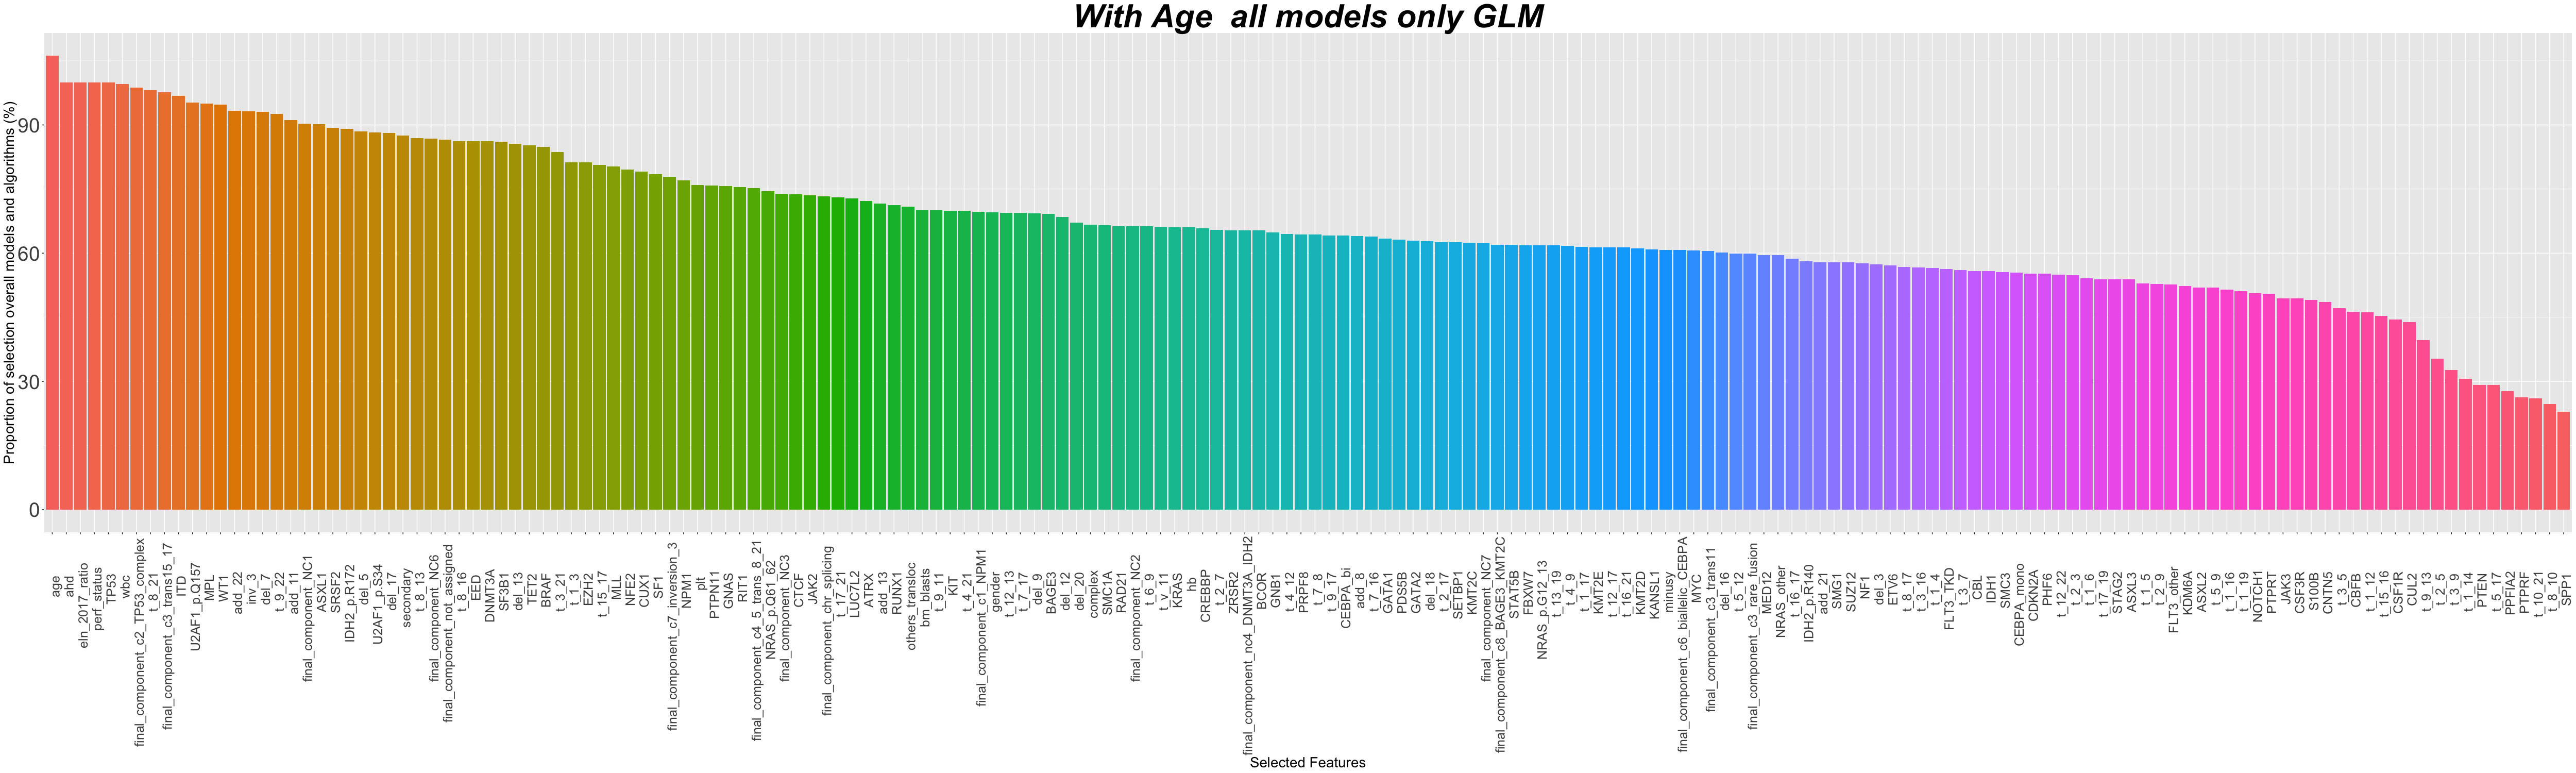

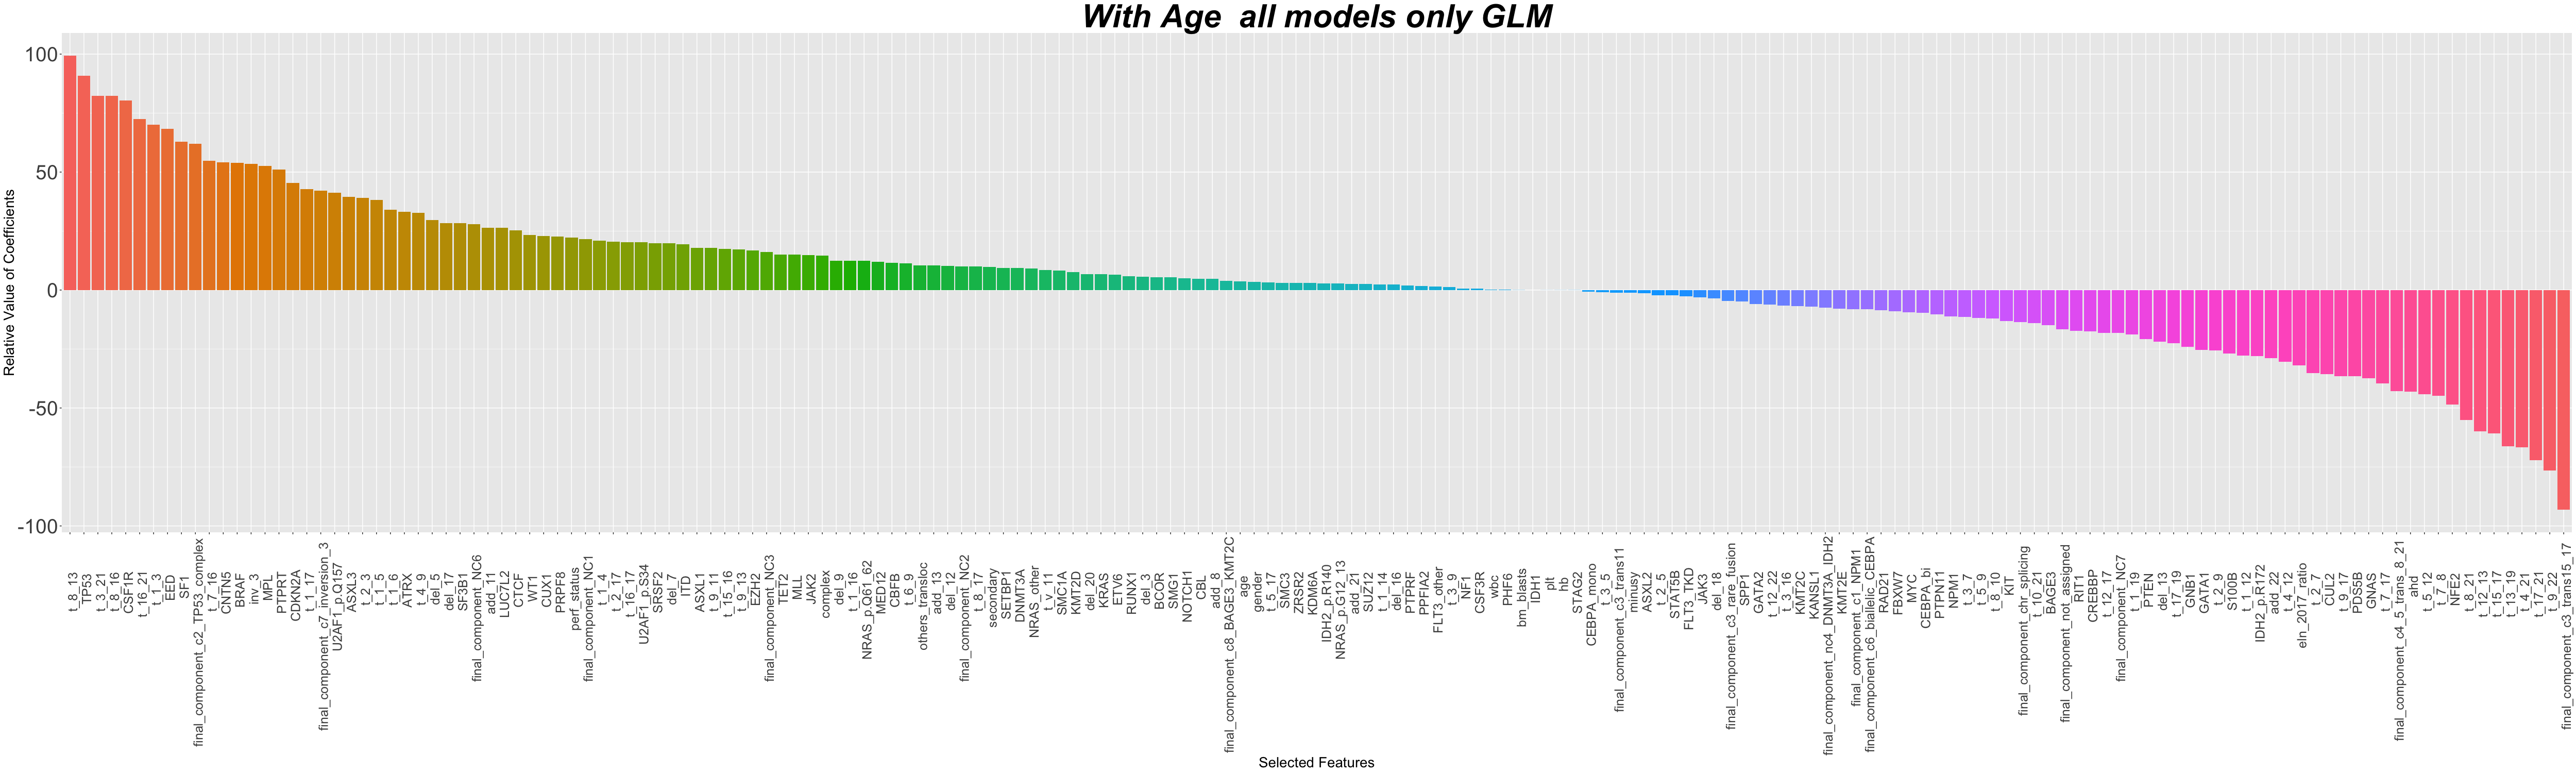

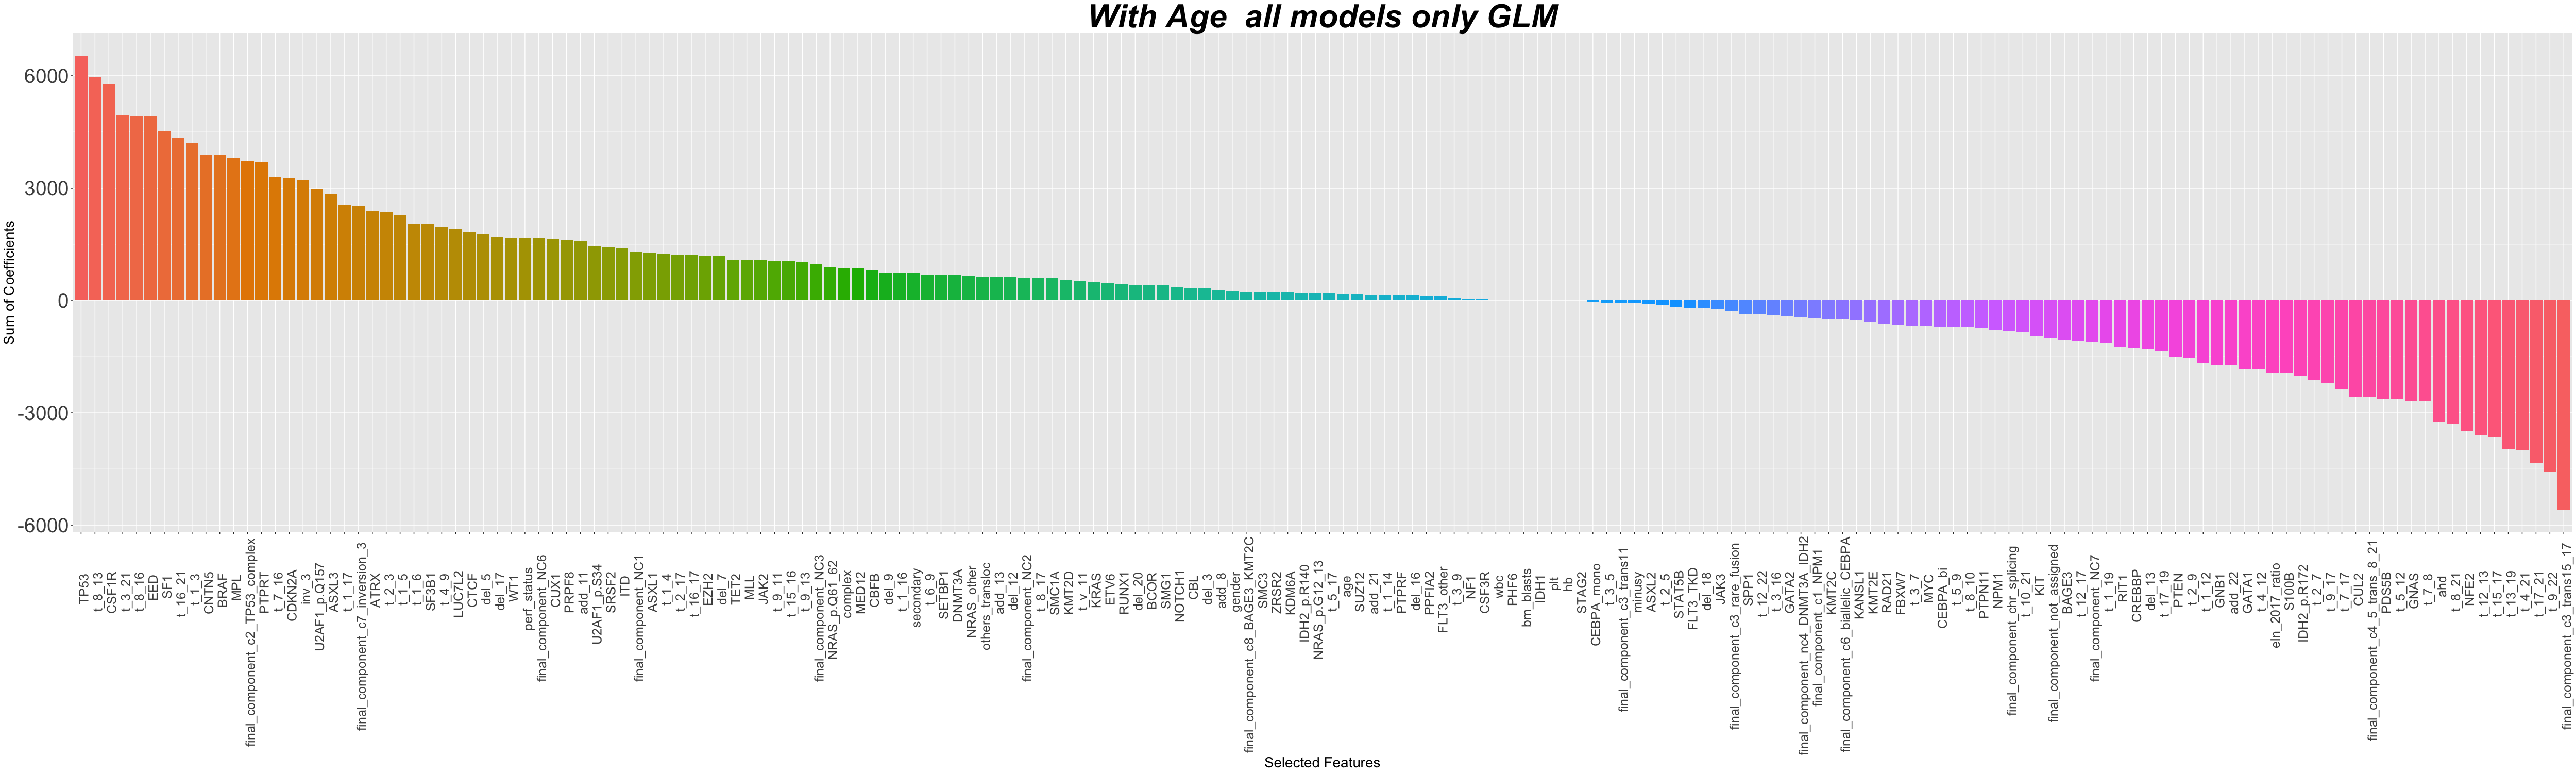

In [35]:
set_notebook_plot_size(50,15)
ggplot(na.omit(all_glm),aes(x=reorder(feature,-proportion_selected),y=proportion_selected))+geom_bar(stat = "identity", aes(fill = reorder(feature,-proportion_selected)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Proportion of selection overall models and algorithms (%)") + ggtitle("With Age  all models only GLM")

ggplot(na.omit(all_glm),aes(x=reorder(feature,-proportion_coefficients),y=proportion_coefficients))+geom_bar(stat = "identity", aes(fill = reorder(feature,-proportion_coefficients)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Relative Value of Coefficients") + ggtitle("With Age  all models only GLM")

ggplot(na.omit(all_glm),aes(x=reorder(feature,-sum_coef),y=sum_coef))+geom_bar(stat = "identity", aes(fill = reorder(feature,-sum_coef)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Sum of Coefficients") + ggtitle("With Age  all models only GLM")


# III WITHOUT AGE )
# III.1)Get Proportion of overall models and algorithms variable importance

In [36]:
count_eln_without_age <- 7
count_clin_without_age <- 7
count_gen_without_age <- 7
count_cyto_without_age <- 7
count_comp_without_age <- 7
count_gender_without_age <- 7

for (l in list.files('../InitialPrognosis/comparison_dataframes/')){
    if (grepl("without_age",l)){
        if (grepl("eln",l)  & !grepl("reduced",l) ){
            count_eln_without_age <-count_eln_without_age+1
        }
        if (grepl("clin",l)  & !grepl("reduced",l) ){
            count_clin_without_age <-count_clin_without_age+1
        }
        if (grepl("gen",l) & !grepl("reduced",l) ){
            count_gen_without_age <-count_gen_without_age+1
        }
        if (grepl("cyto",l)  & !grepl("reduced",l) ){
            count_cyto_without_age <-count_cyto_without_age+1
        }
        if (grepl("comp",l)  & !grepl("reduced",l) ){
            count_comp_without_age <-count_comp_without_age+1
        }
        if (grepl("demo",l)   & !grepl("reduced",l) ){
            count_gender_without_age <-count_gender_without_age+1
        }
        
    }
}
all_without_age <- df_bootstrap[grepl("without_age",df_bootstrap$model_algo),]
all_without_age<- all_without_age[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
all_without_age$proportion_selected <- ifelse(is.element(all_without_age$feature , genes),all_without_age$num_selected/count_gen_without_age,
                                 ifelse(is.element(all_without_age$feature,cyto),all_without_age$num_selected/count_cyto_without_age,
                                       ifelse(is.element(all_without_age$feature,clin),all_without_age$num_selected/count_clin_without_age,
                                             ifelse(is.element(all_without_age$feature,comp),all_without_age$num_selected/count_comp_without_age,
                                                   ifelse(all_without_age$feature=="eln_2017_ratio",all_without_age$num_selected/count_eln_without_age,
                                                       ifelse(all_without_age$feature=="gender",all_without_age$num_selected/count_gender_without_age,0))))))


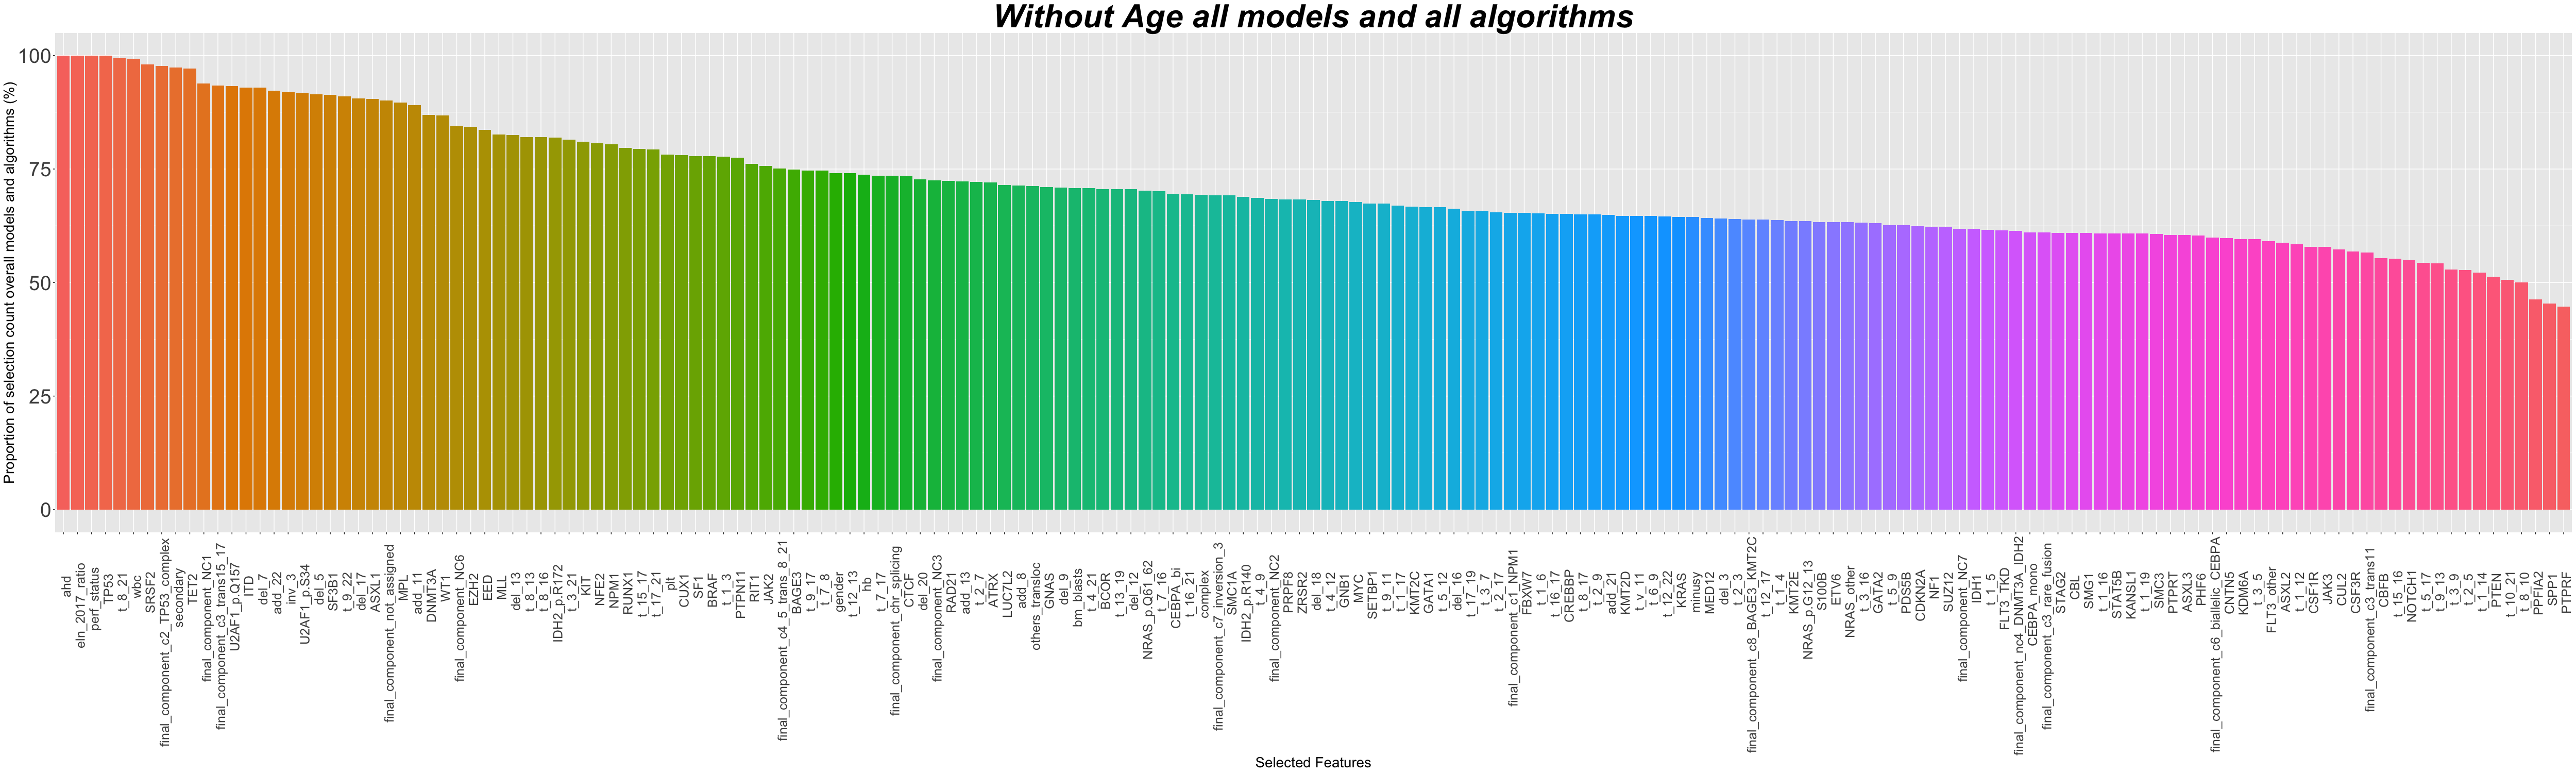

In [37]:
set_notebook_plot_size(50,15)
ggplot(na.omit(all_without_age),aes(x=reorder(feature,-proportion_selected),y=proportion_selected))+geom_bar(stat = "identity", aes(fill = reorder(feature,-proportion_selected)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Proportion of selection count overall models and algorithms (%)") + ggtitle("Without Age all models and all algorithms")


In [38]:
count_eln_glm_without_age <- 3
count_clin_glm_without_age <- 3
count_gen_glm_without_age <- 3
count_cyto_glm_without_age <- 3
count_comp_glm_without_age <- 3
count_gender_glm_without_age <- 3

for (l in list.files('../InitialPrognosis/comparison_dataframes/')){
    if (grepl("without_age",l)){
        if (grepl("eln",l) & grepl("glm",l) & !grepl("reduced",l) ){
            count_eln_glm_without_age <-count_eln_glm_without_age+1
        }
        if (grepl("clin",l) & grepl("glm",l) & !grepl("reduced",l) ){
            count_clin_glm_without_age <-count_clin_glm_without_age+1
        }
        if (grepl("gen",l) & grepl("glm",l) & !grepl("reduced",l) ){
            count_gen_glm_without_age <-count_gen_glm_without_age+1
        }
        if (grepl("cyto",l) & grepl("glm",l) & !grepl("reduced",l) ){
            count_cyto_glm_without_age <-count_cyto_glm_without_age+1
        }
        if (grepl("comp",l) & grepl("glm",l) & !grepl("reduced",l) ){
            count_comp_glm_without_age <-count_comp_glm_without_age+1
        }
        if (grepl("demo",l)  & grepl("glm",l) & !grepl("reduced",l) ){
            count_gender_glm_without_age <-count_gender_glm_without_age+1
        }
    }
}

all_glm_without_age <- df_bootstrap[grepl("glm",df_bootstrap$model_algo) & grepl("without_age",df_bootstrap$model_algo),]
all_glm_without_age <- all_glm_without_age[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
all_glm_without_age$proportion_selected <- ifelse(is.element(all_glm_without_age$feature , genes),all_glm_without_age$num_selected/count_gen_glm_without_age,
                                 ifelse(is.element(all_glm_without_age$feature,cyto),all_glm_without_age$num_selected/count_cyto_glm_without_age,
                                       ifelse(is.element(all_glm_without_age$feature,clin),all_glm_without_age$num_selected/count_clin_glm_without_age,
                                             ifelse(is.element(all_glm_without_age$feature,comp),all_glm_without_age$num_selected/count_comp_glm_without_age,
                                                   ifelse(all_glm_without_age$feature=="eln_2017_ratio",all_glm_without_age$num_selected/count_eln_glm_without_age,
                                                       ifelse(all_glm_without_age$feature=="gender",all_glm_without_age$num_selected/count_gender_glm_without_age,0))))))

all_glm_without_age$proportion_coefficients <- ifelse(is.element(all_glm_without_age$feature , genes),all_glm_without_age$sum_coef/count_gen_glm_without_age,
                                 ifelse(is.element(all_glm_without_age$feature,cyto),all_glm_without_age$sum_coef/count_cyto_glm_without_age,
                                       ifelse(is.element(all_glm_without_age$feature,clin),all_glm_without_age$sum_coef/count_clin_glm_without_age,
                                             ifelse(is.element(all_glm_without_age$feature,comp),all_glm_without_age$sum_coef/count_comp_glm_without_age,
                                                   ifelse(all_glm_without_age$feature=="eln_2017_ratio",all_glm_without_age$sum_coef/count_eln_glm_without_age,
                                                       ifelse(all_glm_without_age$feature=="gender",all_glm_without_age$sum_coef/count_gender_glm_without_age,0))))))


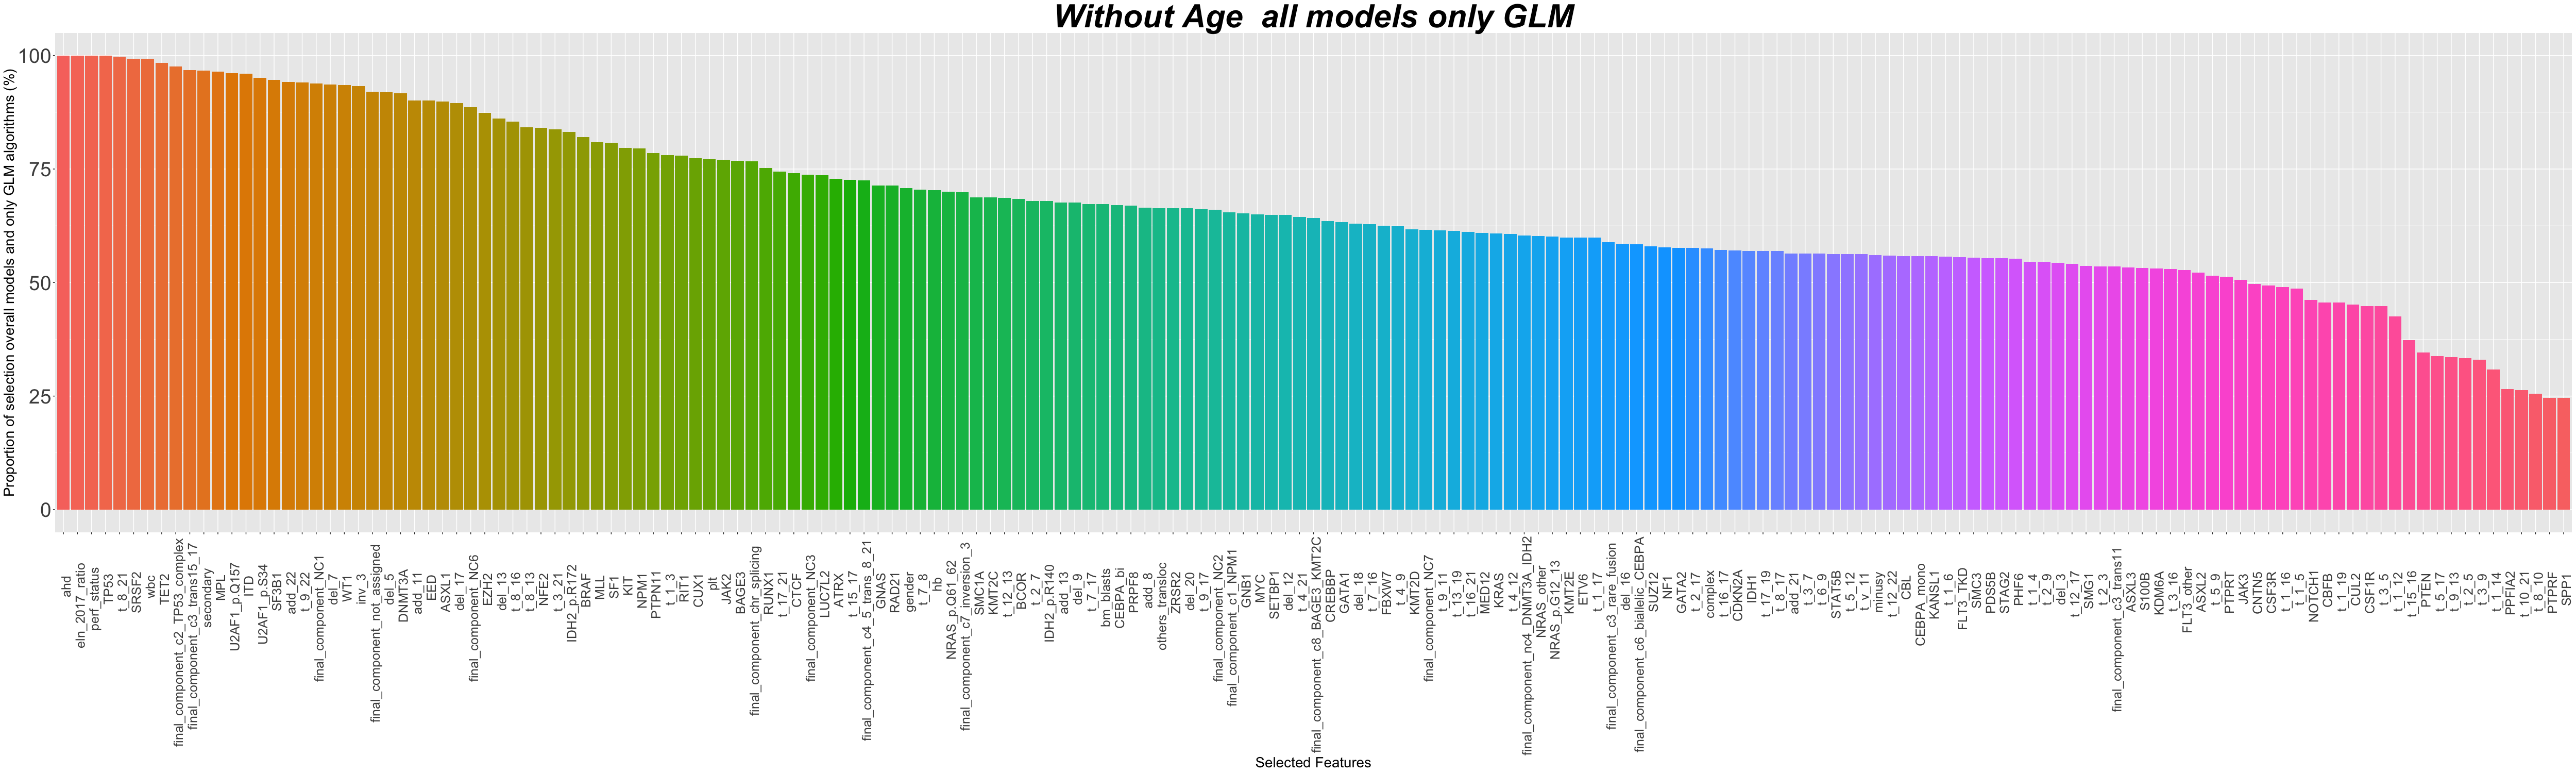

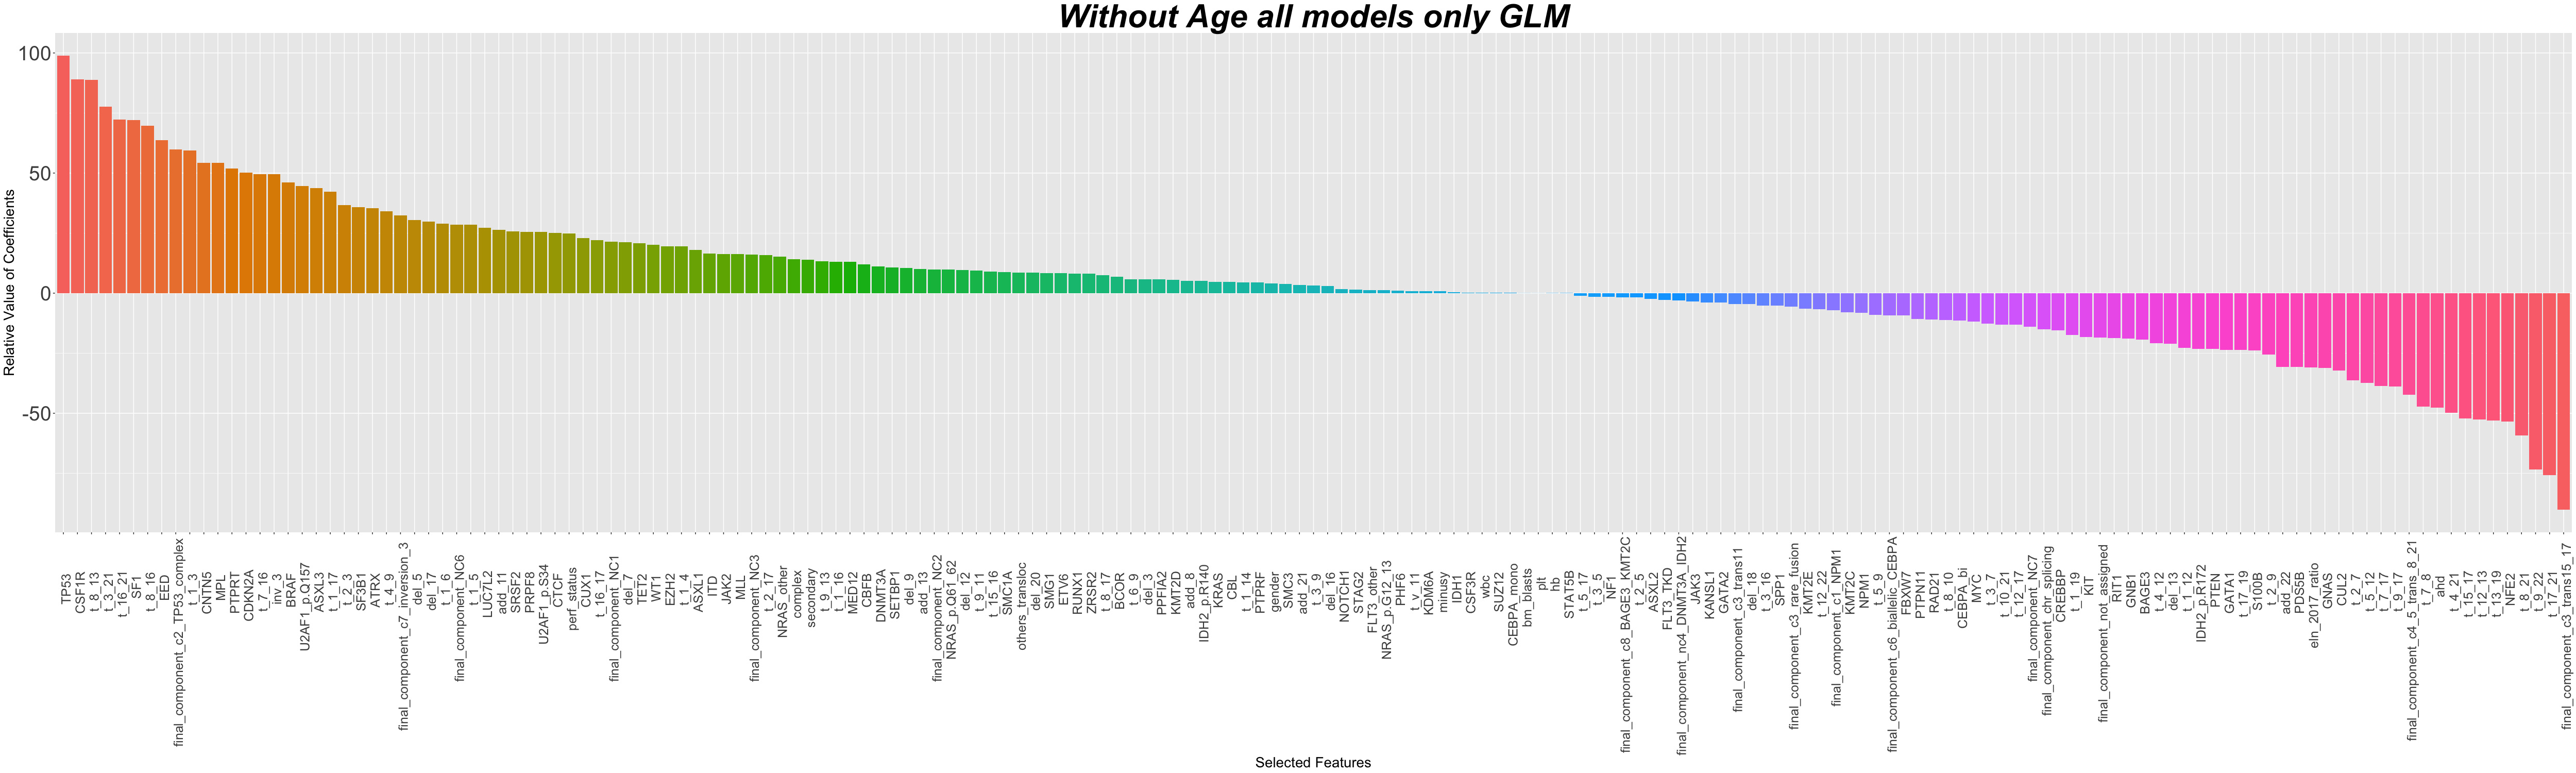

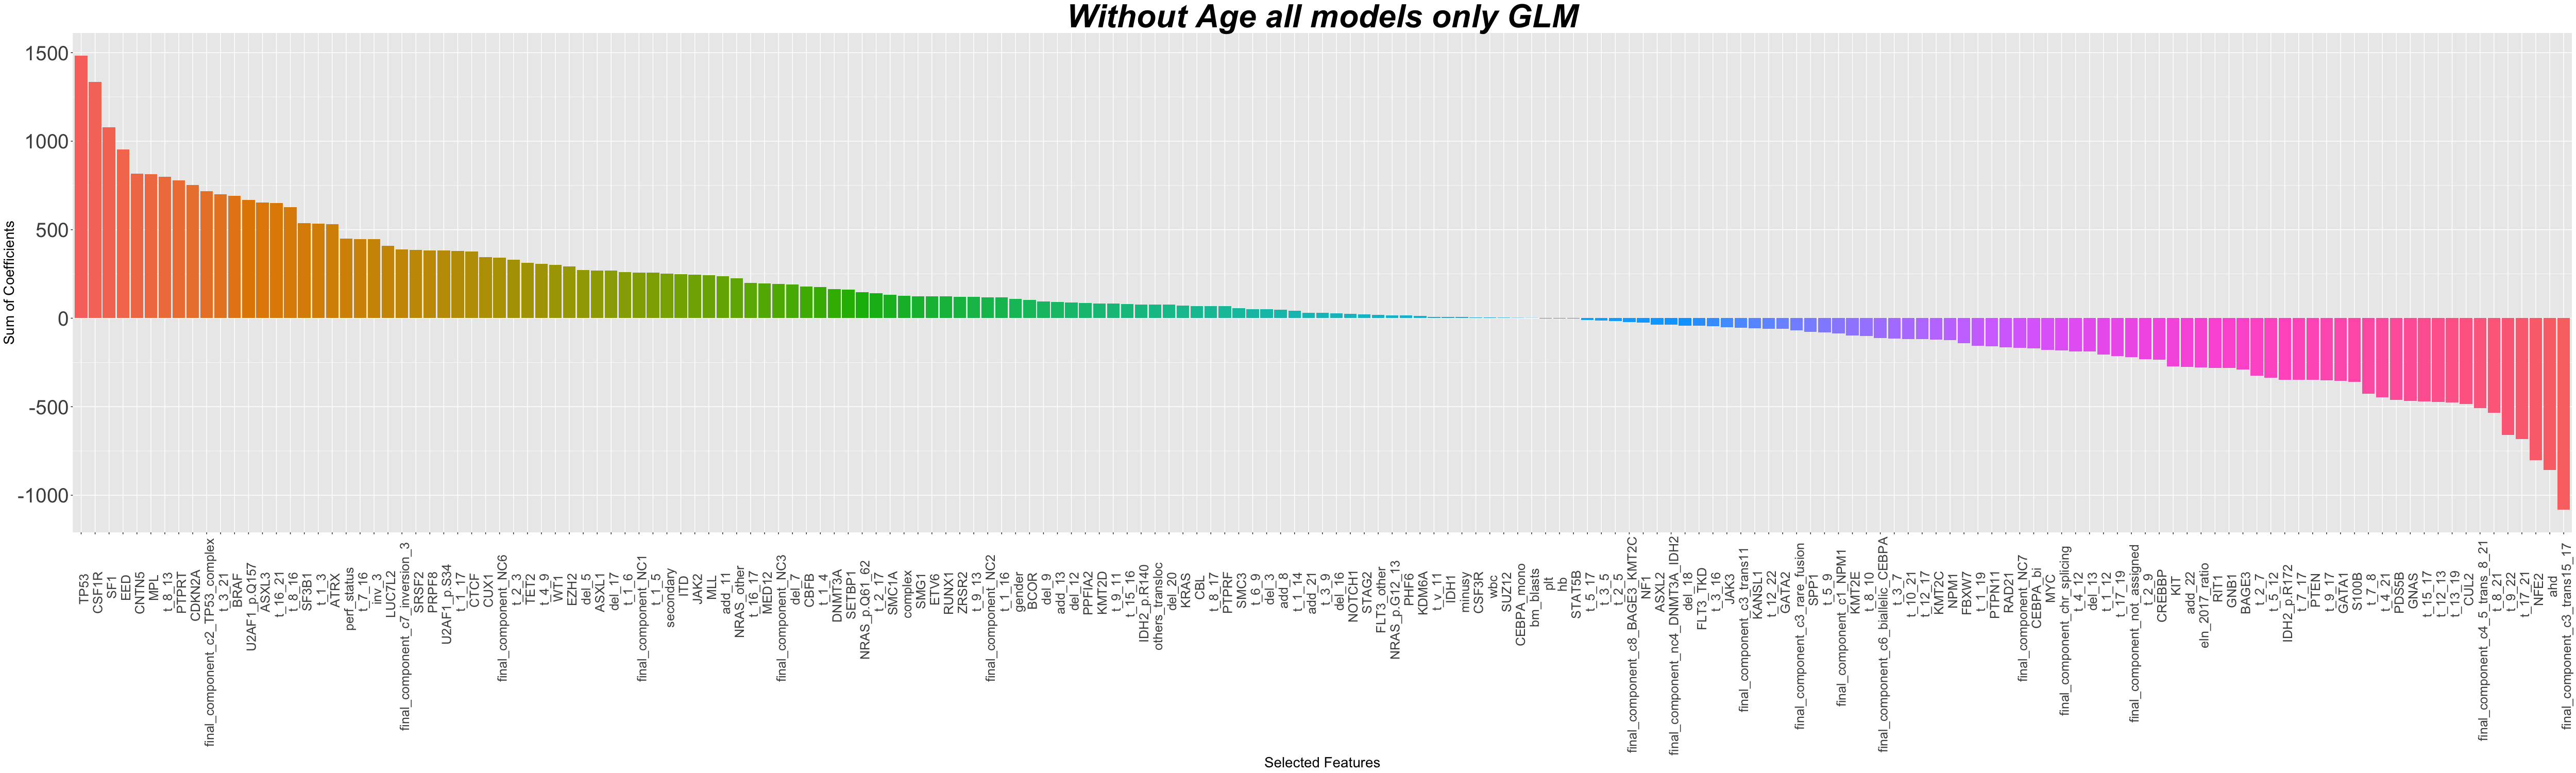

In [39]:
set_notebook_plot_size(50,15)
ggplot(na.omit(all_glm_without_age),aes(x=reorder(feature,-proportion_selected),y=proportion_selected))+geom_bar(stat = "identity", aes(fill = reorder(feature,-proportion_selected)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+
xlab("Selected Features") +ylab("Proportion of selection overall models and only GLM algorithms (%)") + ggtitle("Without Age  all models only GLM")


ggplot(na.omit(all_glm_without_age),aes(x=reorder(feature,-proportion_coefficients),y=proportion_coefficients))+geom_bar(stat = "identity", aes(fill = reorder(feature,-proportion_coefficients)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Relative Value of Coefficients") + ggtitle("Without Age all models only GLM")

ggplot(na.omit(all_glm_without_age),aes(x=reorder(feature,-sum_coef),y=sum_coef))+geom_bar(stat = "identity", aes(fill = reorder(feature,-sum_coef)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features")+ 
ylab("Sum of Coefficients") + ggtitle("Without Age all models only GLM")


In [105]:
dim(all)

[1] 181   4

# Comparison all features coefficient and number of selection : ALL FEATURES WITH AGE AND WITHOUT AGE

In [90]:
all_features <- df_bootstrap[startsWith(df_bootstrap$model_algo,"all_features_bootstrap"),]
all_features <- all_features[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
all_features$proportion_selected <- all_features$num_selected /7
all_features$model <- "all_features"

all_features_without_age <- df_bootstrap[startsWith(df_bootstrap$model_algo,"all_features_without_age_bootstrap"),]
all_features_without_age <- all_features_without_age[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
all_features_without_age$proportion_selected <- all_features_without_age$num_selected /7
all_features_without_age$model <- "all_features_without_age"
tmp <-rbind(all_features,all_features_without_age)


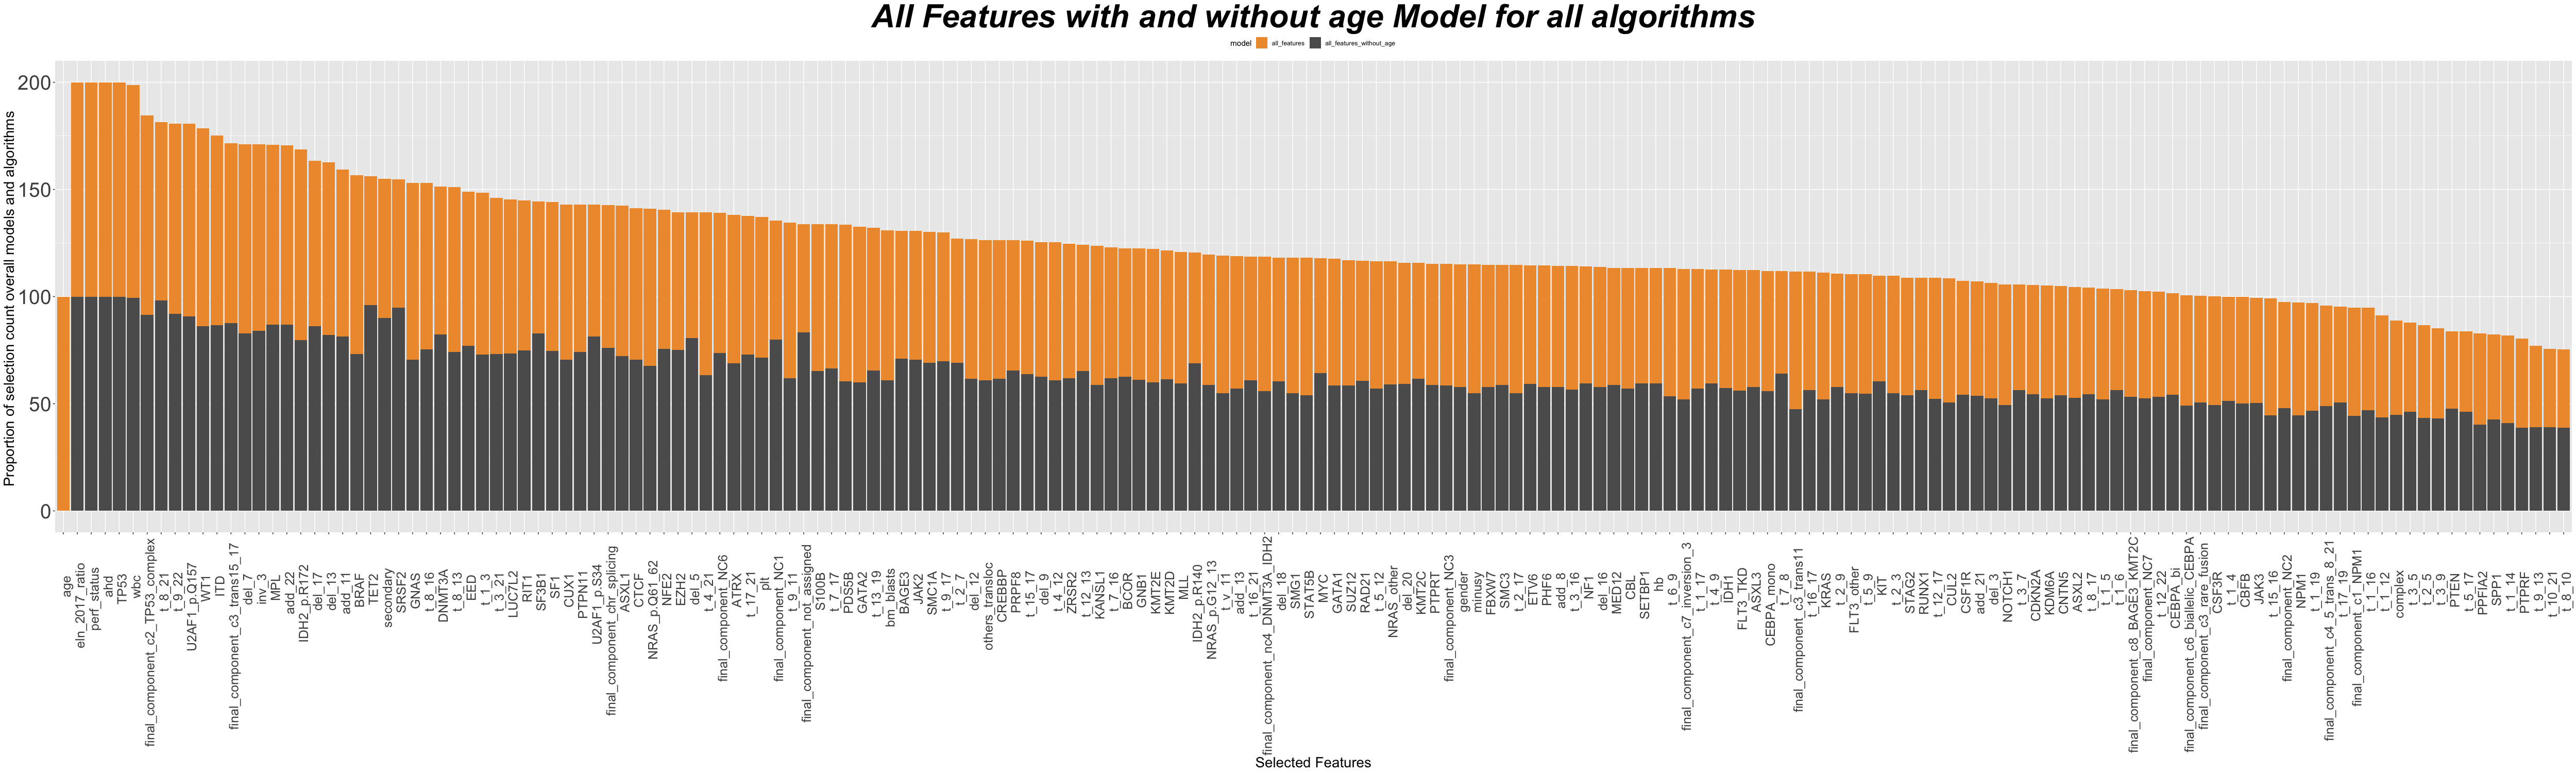

In [102]:
#tmp <-rbind(all_features,all_features_without_age)
ggplot(na.omit(tmp),aes(x=reorder(feature,-proportion_selected),y=proportion_selected,fill=model))+geom_bar(stat = "identity")+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Proportion of selection count overall models and algorithms ") + ggtitle("All Features with and without age Model for all algorithms") + scale_fill_manual(values=c("#EE9937","#5C5C5C"))


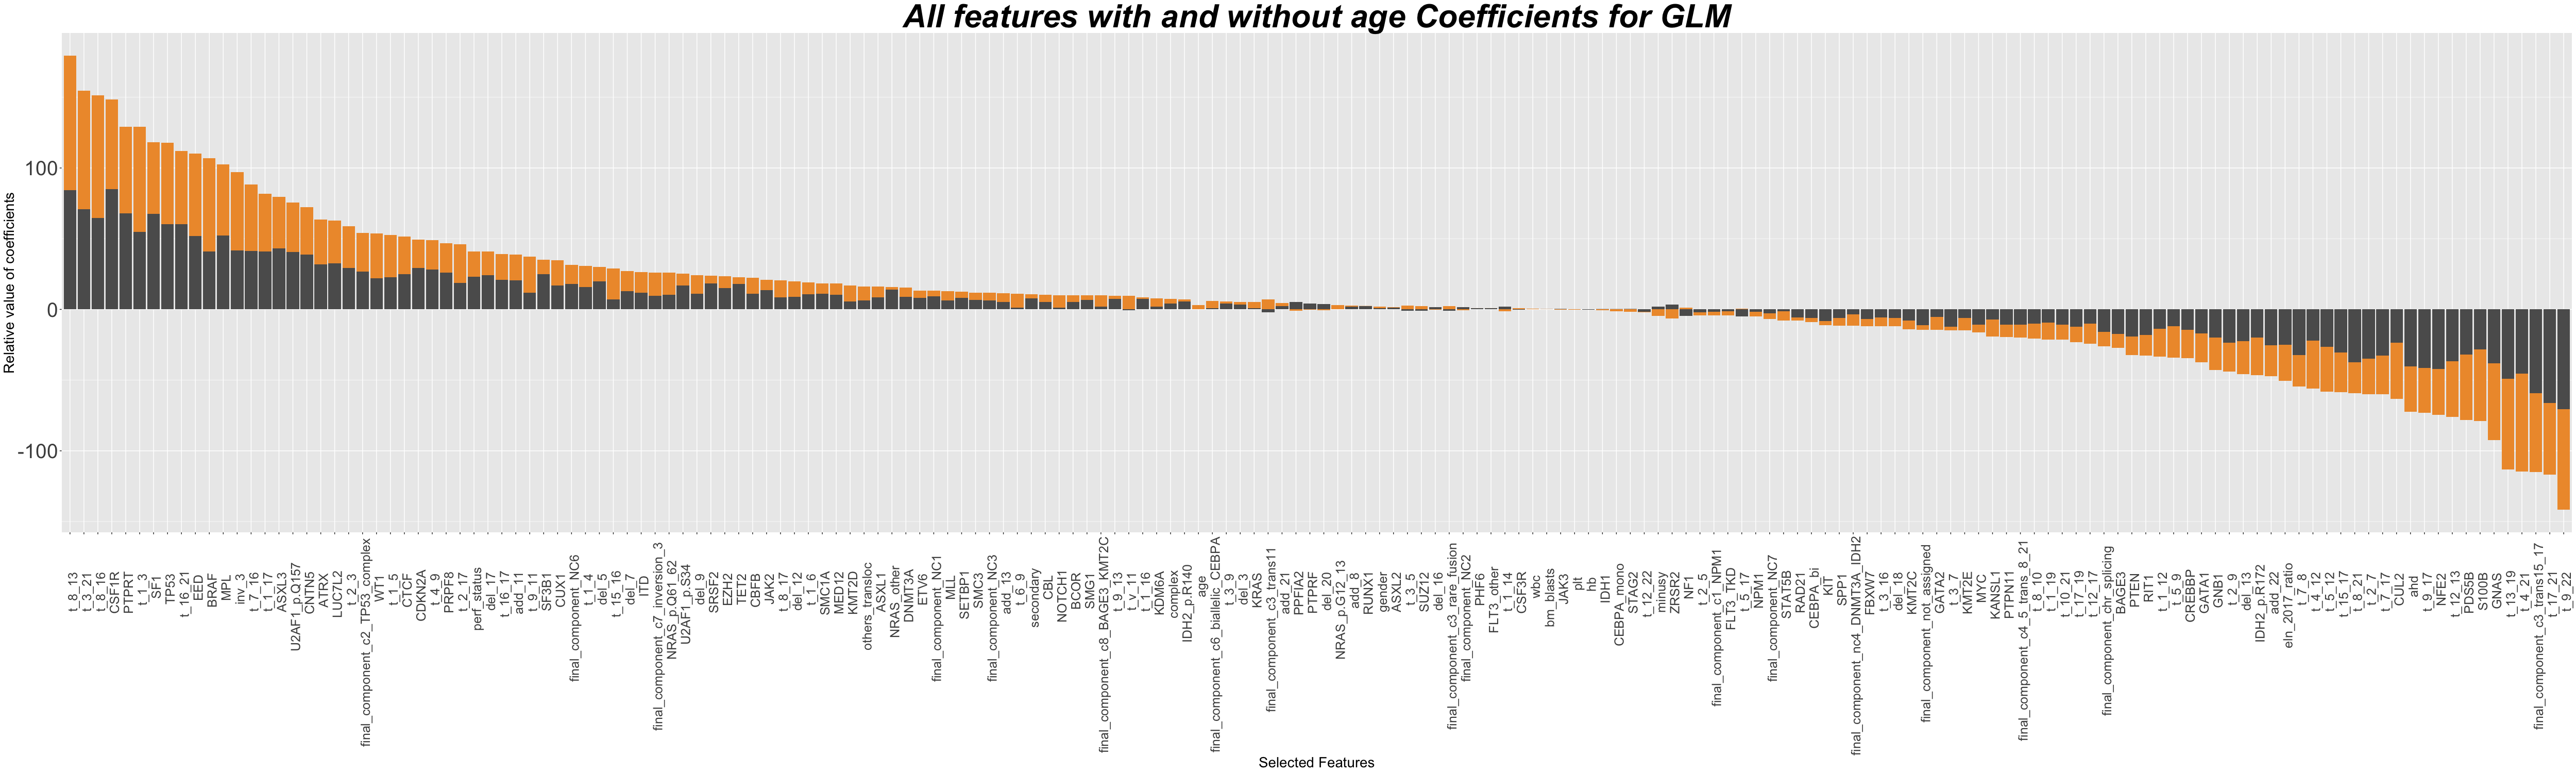

In [103]:
all_features_glm <- df_bootstrap[startsWith(df_bootstrap$model_algo,"all_features_bootstrap_glm"),]
all_features_glm <- all_features_glm[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
all_features_glm$proportion_coefficients <- all_features_glm$sum_coef /3
all_features_glm$model <- "all_features"

all_features_without_age_glm <- df_bootstrap[startsWith(df_bootstrap$model_algo,"all_features_without_age_bootstrap_glm"),]
all_features_without_age_glm <- all_features_without_age_glm[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
all_features_without_age_glm$proportion_coefficients <- all_features_without_age_glm$sum_coef /3
all_features_without_age_glm$model <- "all_features_without_age"
tmp_glm <-rbind(all_features_glm,all_features_without_age_glm)
set_notebook_plot_size(50,15)
ggplot(na.omit(tmp_glm),aes(x=reorder(feature,-proportion_coefficients),y=proportion_coefficients,fill=model))+geom_bar(stat = "identity")+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Relative value of coefficients") + ggtitle("All features with and without age Coefficients for GLM")+ scale_fill_manual(values=c("#EE9937","#5C5C5C"))


In [75]:
all_features <- df_bootstrap[startsWith(df_bootstrap$model_algo,"all_features_bootstrap"),]
all_features <- all_features[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
all_features$proportion_selected <- all_features$num_selected /7

all_features_without_age <- df_bootstrap[startsWith(df_bootstrap$model_algo,"all_features_without_age_bootstrap"),]
all_features_without_age <- all_features_without_age[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
all_features_without_age$proportion_selected <- all_features_without_age$num_selected /7

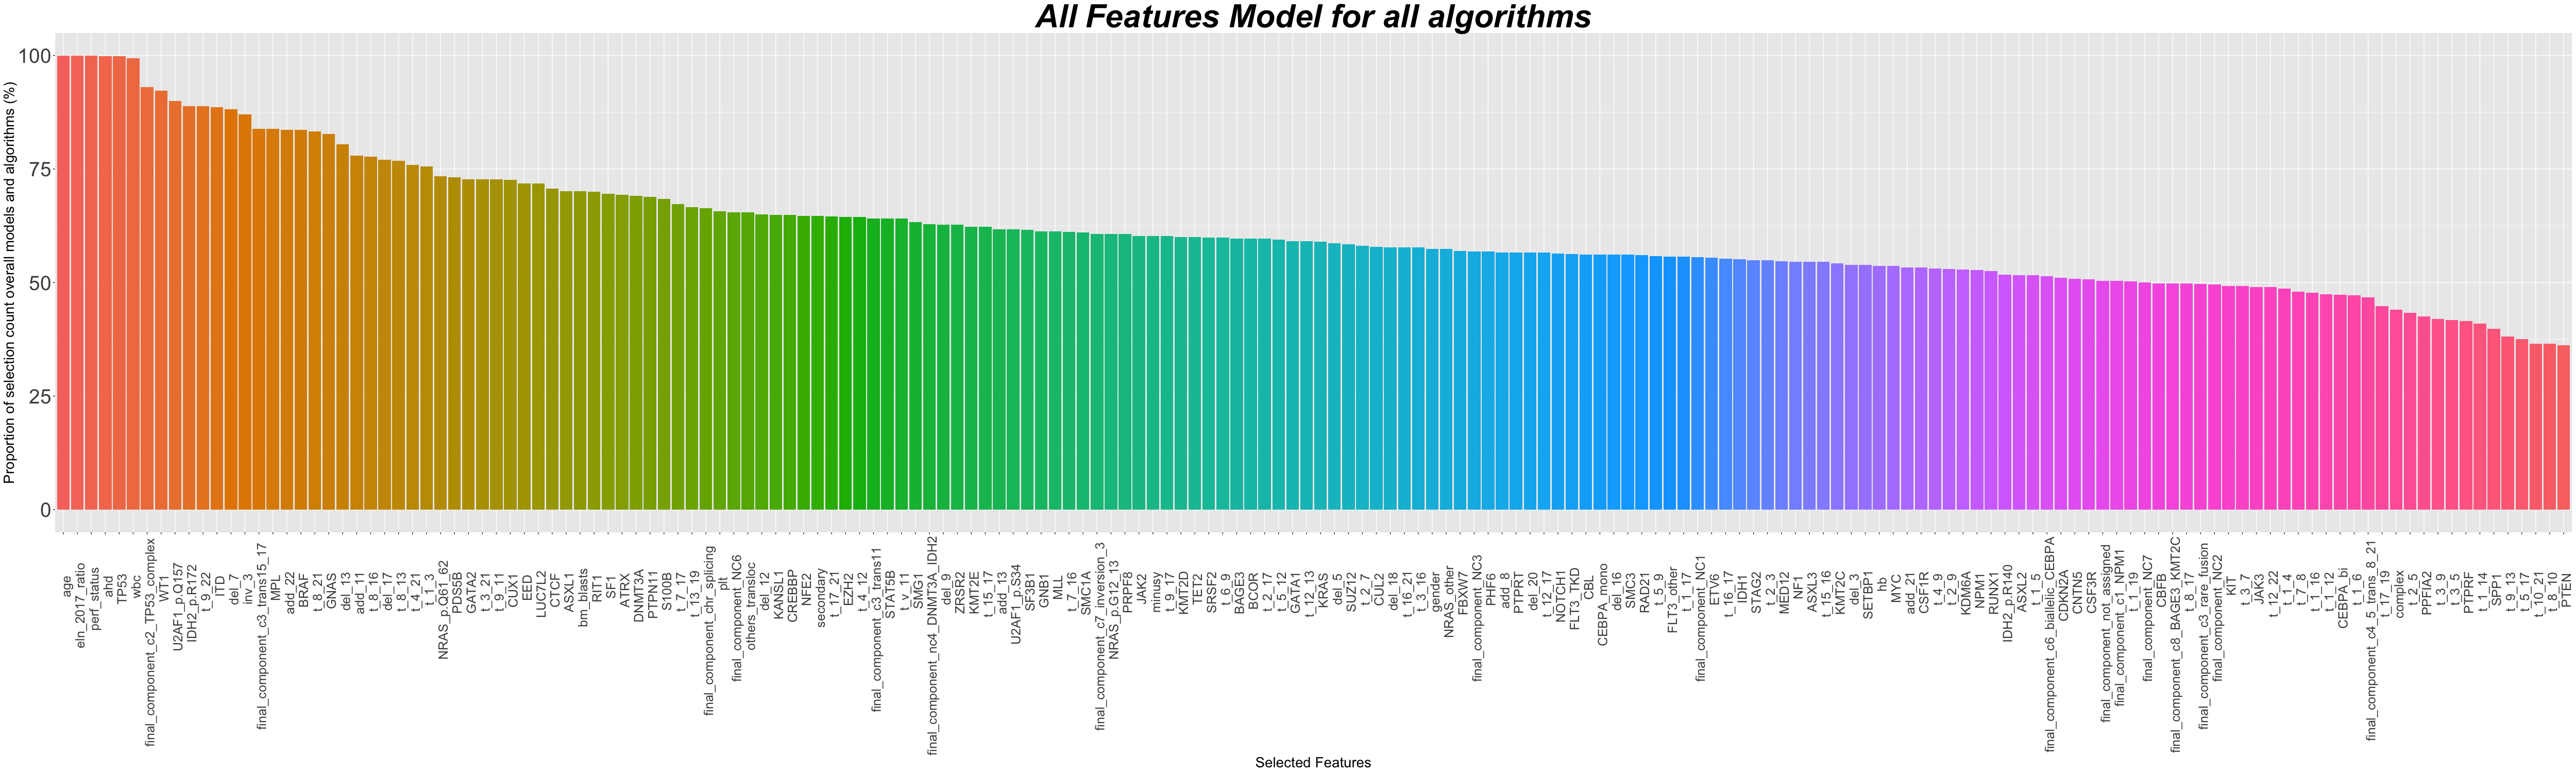

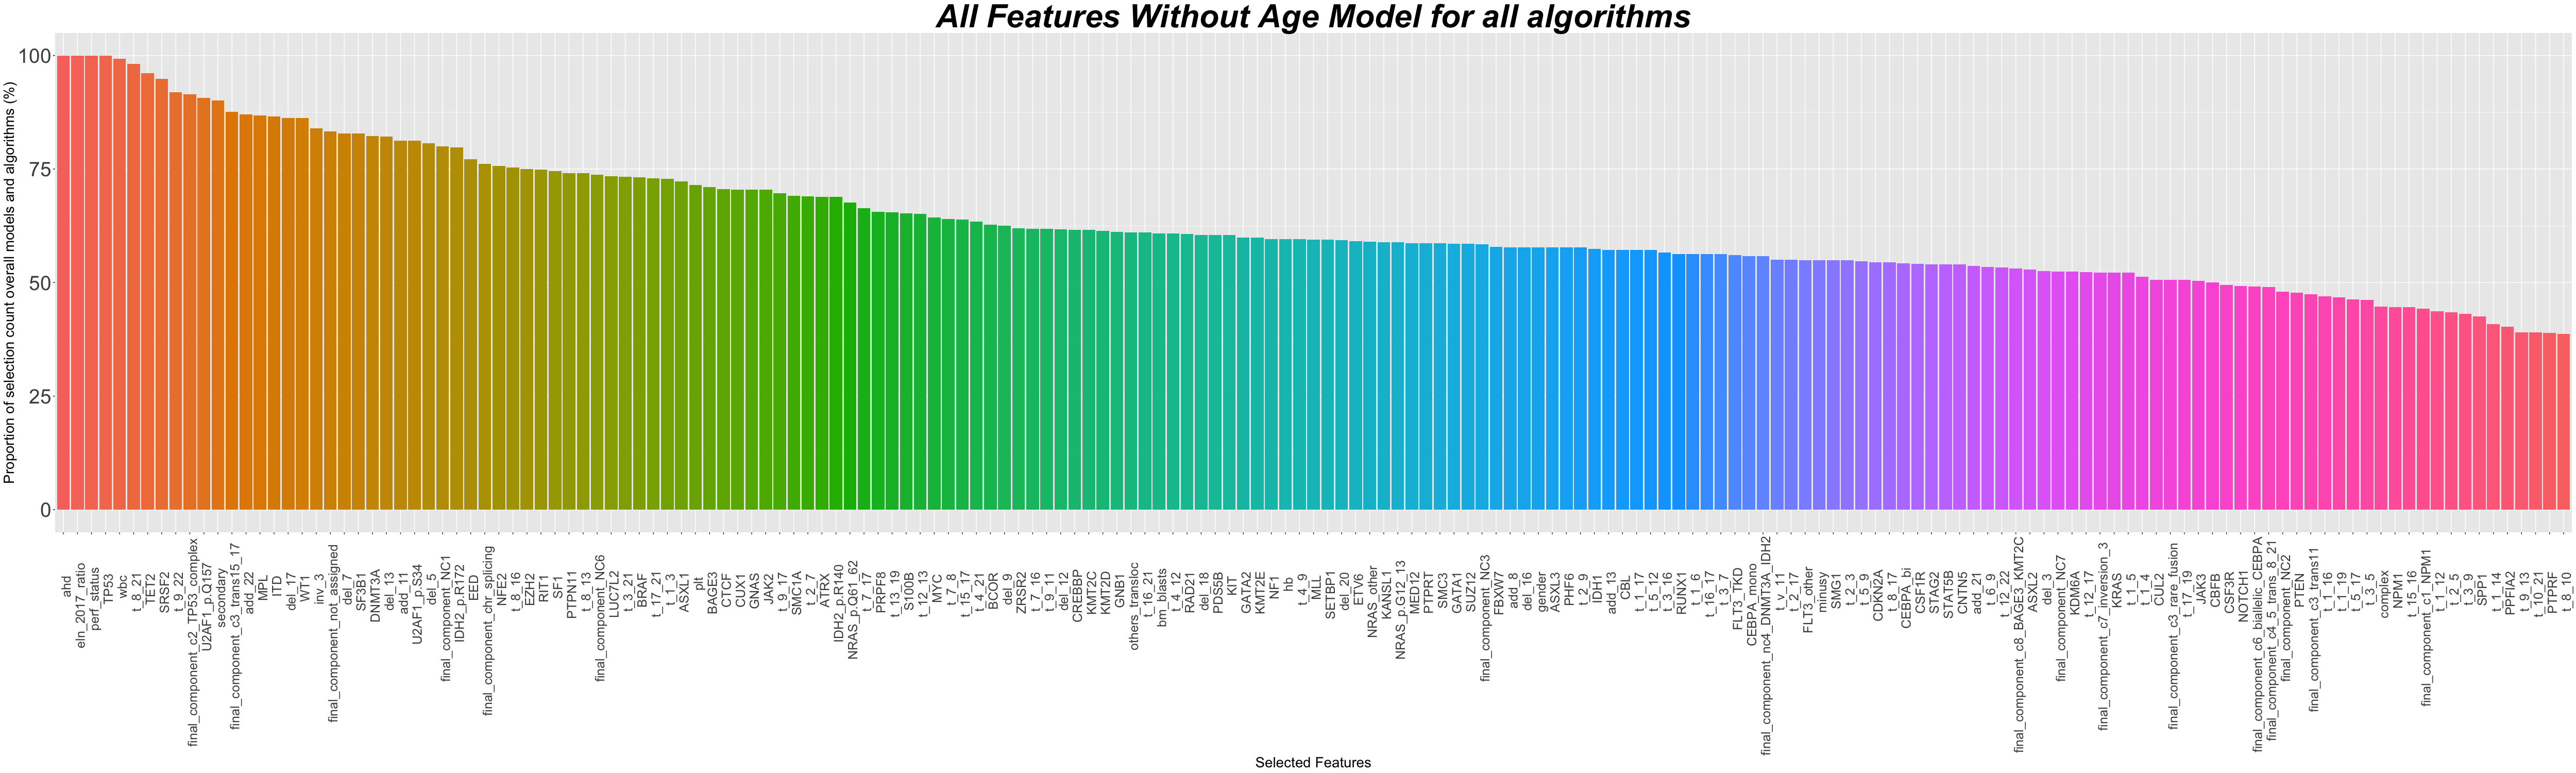

In [76]:
set_notebook_plot_size(50,15)
ggplot(na.omit(all_features),aes(x=reorder(feature,-proportion_selected),y=proportion_selected))+geom_bar(stat = "identity", aes(fill = reorder(feature,-proportion_selected)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Proportion of selection count overall models and algorithms (%)") + ggtitle("All Features Model for all algorithms")

ggplot(na.omit(all_features_without_age),aes(x=reorder(feature,-proportion_selected),y=proportion_selected))+geom_bar(stat = "identity", aes(fill = reorder(feature,-proportion_selected)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Proportion of selection count overall models and algorithms (%)") + ggtitle("All Features Without Age Model for all algorithms")

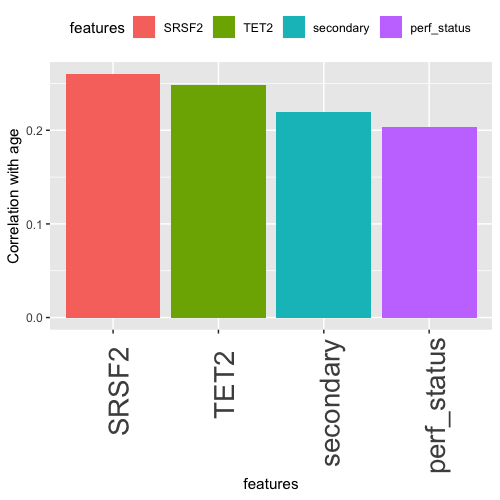

In [41]:
set_notebook_plot_size(5,5)
age <- data.frame(data.frame(rcorr(as.matrix(df_final[,1:163]),type='pearson')$r)$age,row.names=rownames(data.frame(rcorr(as.matrix(df_final[,1:163]))$r)))
colnames(age) <- "age_corr"
age$features <- rownames(age)
age <- age[age$age_corr>0.2 | age$age_corr< -0.2 ,]
age <- age[order(age$age_corr,decreasing=T),]
age$features <- factor(age$features, levels = age$features)
ggplot(age[age$features!="age",],aes(x=features,y=age_corr))+geom_bar(stat = "identity", aes(fill = features))+
theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=20))+ylab("Correlation with age")

# IV - GENE AND CYTO

In [42]:
gen_cyto <- df_bootstrap[startsWith(df_bootstrap$model_algo,"cyto_gen_bootstrap"),]
gen_cyto <- gen_cyto[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
gen_cyto$proportion_selected <- gen_cyto$num_selected /7


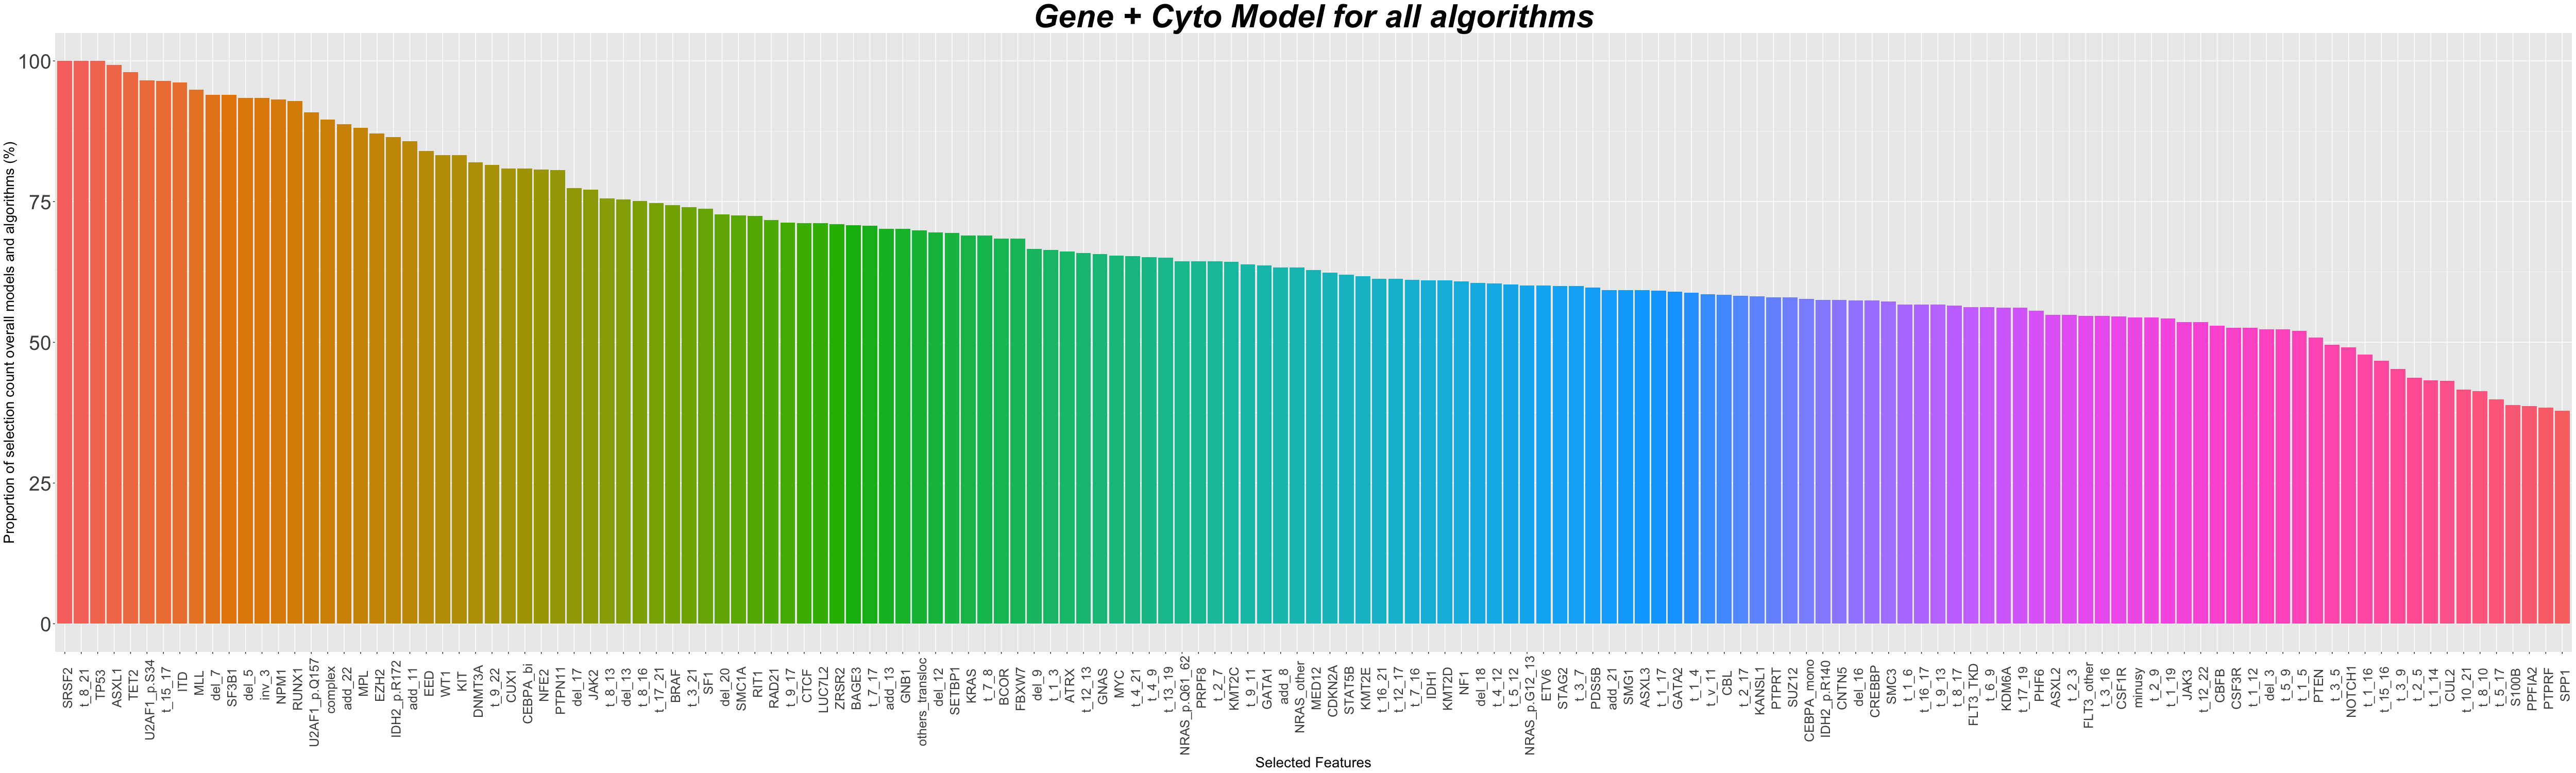

In [43]:
set_notebook_plot_size(50,15)
ggplot(na.omit(gen_cyto),aes(x=reorder(feature,-proportion_selected),y=proportion_selected))+geom_bar(stat = "identity", aes(fill = reorder(feature,-proportion_selected)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Proportion of selection count overall models and algorithms (%)") + ggtitle("Gene + Cyto Model for all algorithms")

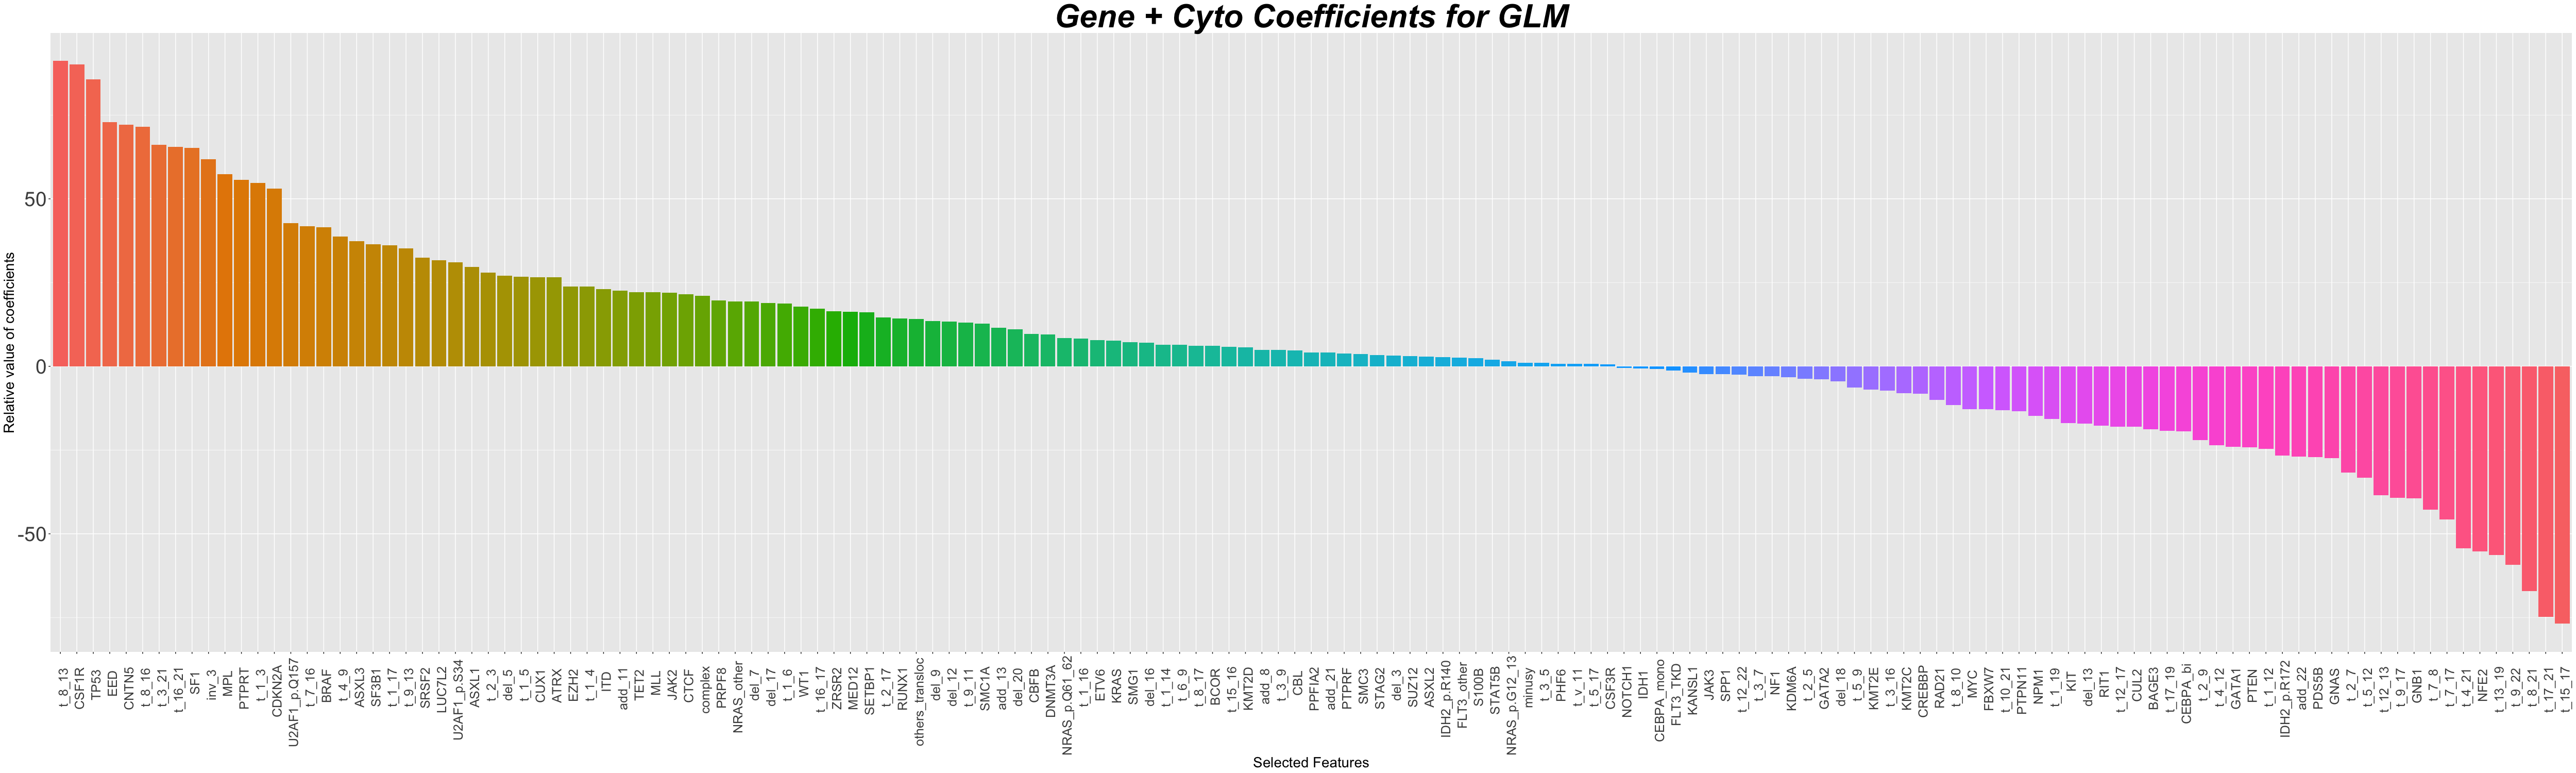

In [44]:
gen_cyto_glm <- df_bootstrap[startsWith(df_bootstrap$model_algo,"cyto_gen_bootstrap_glm"),]
gen_cyto_glm <- gen_cyto_glm[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
gen_cyto_glm$proportion_coefficients <- gen_cyto_glm$sum_coef /3
set_notebook_plot_size(50,15)
ggplot(na.omit(gen_cyto_glm),aes(x=reorder(feature,-proportion_coefficients),y=proportion_coefficients))+geom_bar(stat = "identity", aes(fill = reorder(feature,-proportion_coefficients)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Relative value of coefficients") + ggtitle("Gene + Cyto Coefficients for GLM")

# ELN COMP

In [46]:
eln_comp <- df_bootstrap[startsWith(df_bootstrap$model_algo,"eln_comp_bootstrap"),]
eln_comp <- eln_comp[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
eln_comp$proportion_selected <- eln_comp$num_selected /7


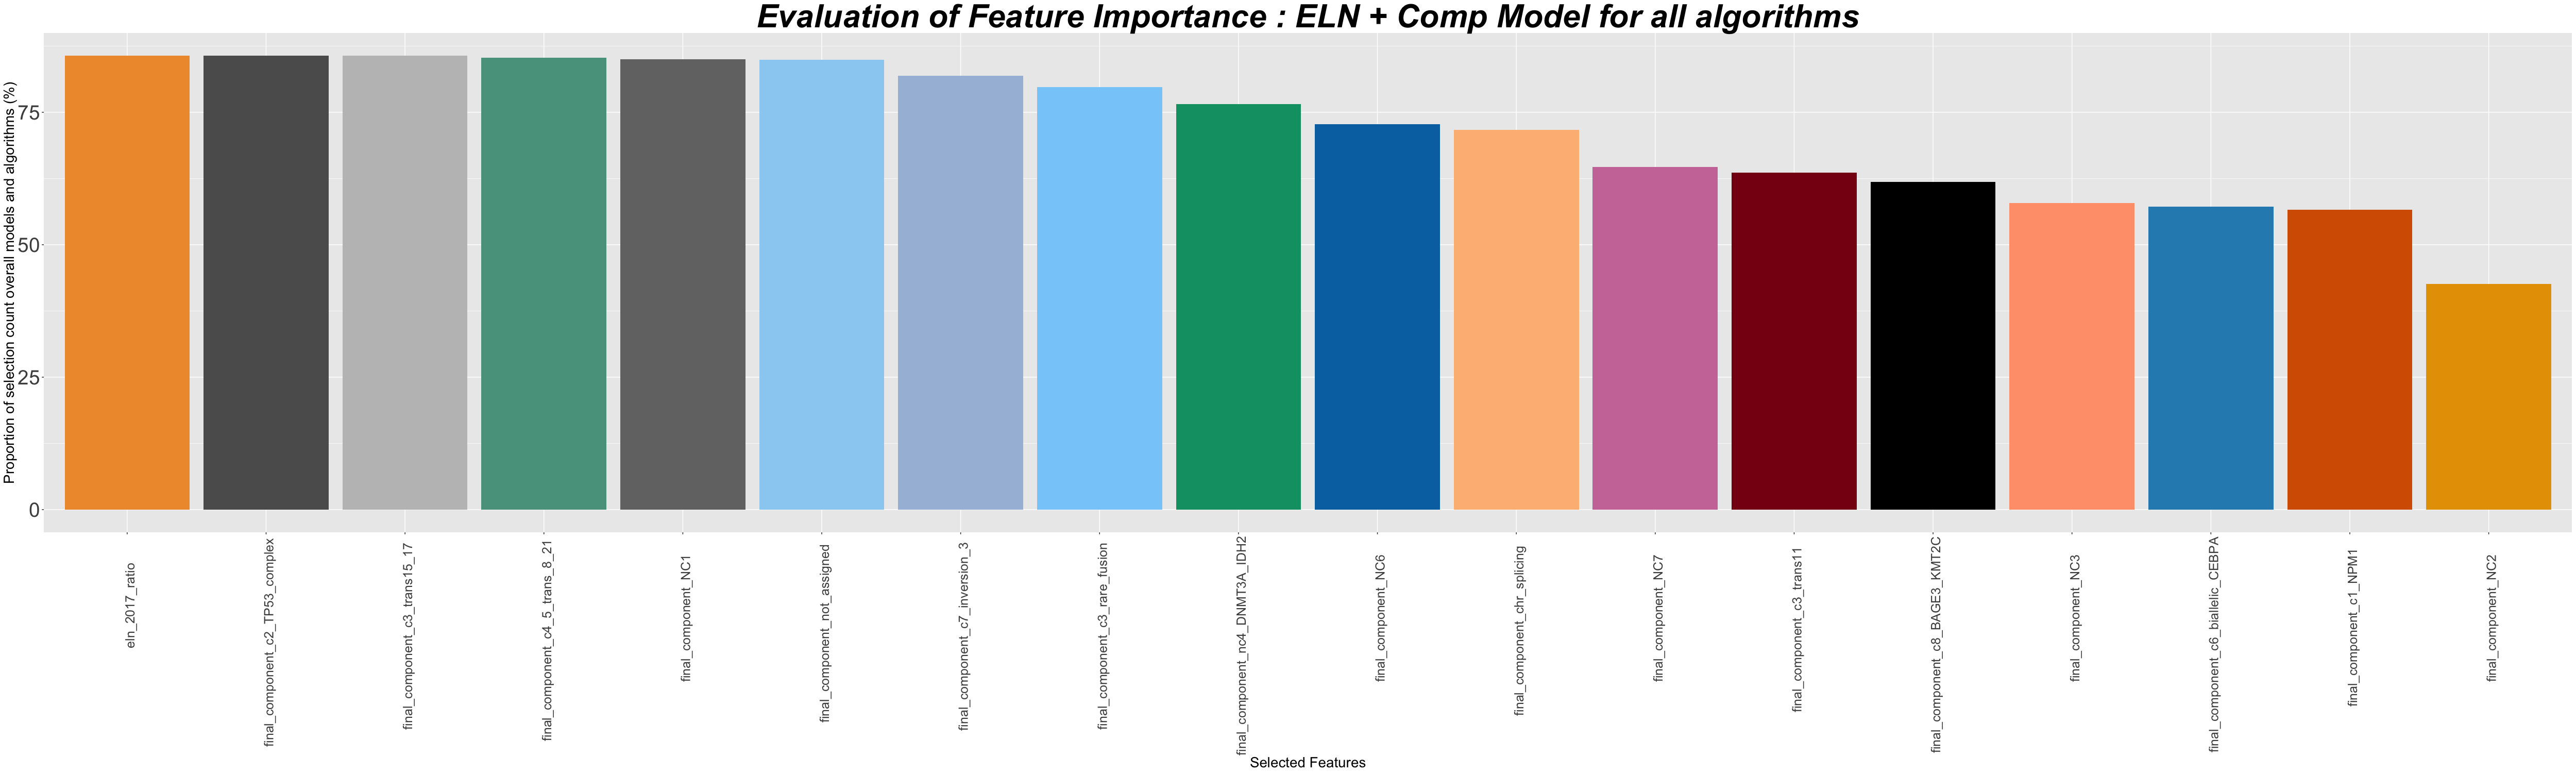

In [60]:
set_notebook_plot_size(50,15)
cols <- c("eln_2017_ratio" = "#EE9937", "final_component_c2_TP53_complex" = "#5C5C5C", "final_component_c3_trans11" = "#870C14", "final_component_c3_trans15_17" = "#BFBFBF",
         "final_component_c4_5_trans_8_21" = "#59A08B", "final_component_c6_biallelic_CEBPA" = "#2b8cbe", "final_component_c7_inversion_3" = "#a6bddb", "final_component_chr_splicing" = "#fdbb84",
         "final_component_NC1" = "grey45", "final_component_NC2" = "#e79f00", "final_component_nc4_DNMT3A_IDH2" = "#009E73", "final_component_NC6" = "#0072B2",
         "final_component_NC7" = "#CC79A7", "final_component_not_assigned" = "#9ad0f3", "final_component_c1_NPM1" = "#D55E00", "final_component_c3_rare_fusion" = "lightskyblue",
         "final_component_c8_BAGE3_KMT2C" = "#000000", "final_component_NC3" = "lightsalmon")
ggplot(na.omit(eln_comp),aes(x=reorder(feature,-proportion_selected),y=proportion_selected))+geom_bar(stat = "identity", aes(fill = reorder(feature,-proportion_selected)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Proportion of selection count overall models and algorithms (%)") + ggtitle("Evaluation of Feature Importance : ELN + Comp Model for all algorithms")+scale_fill_manual(values = cols)

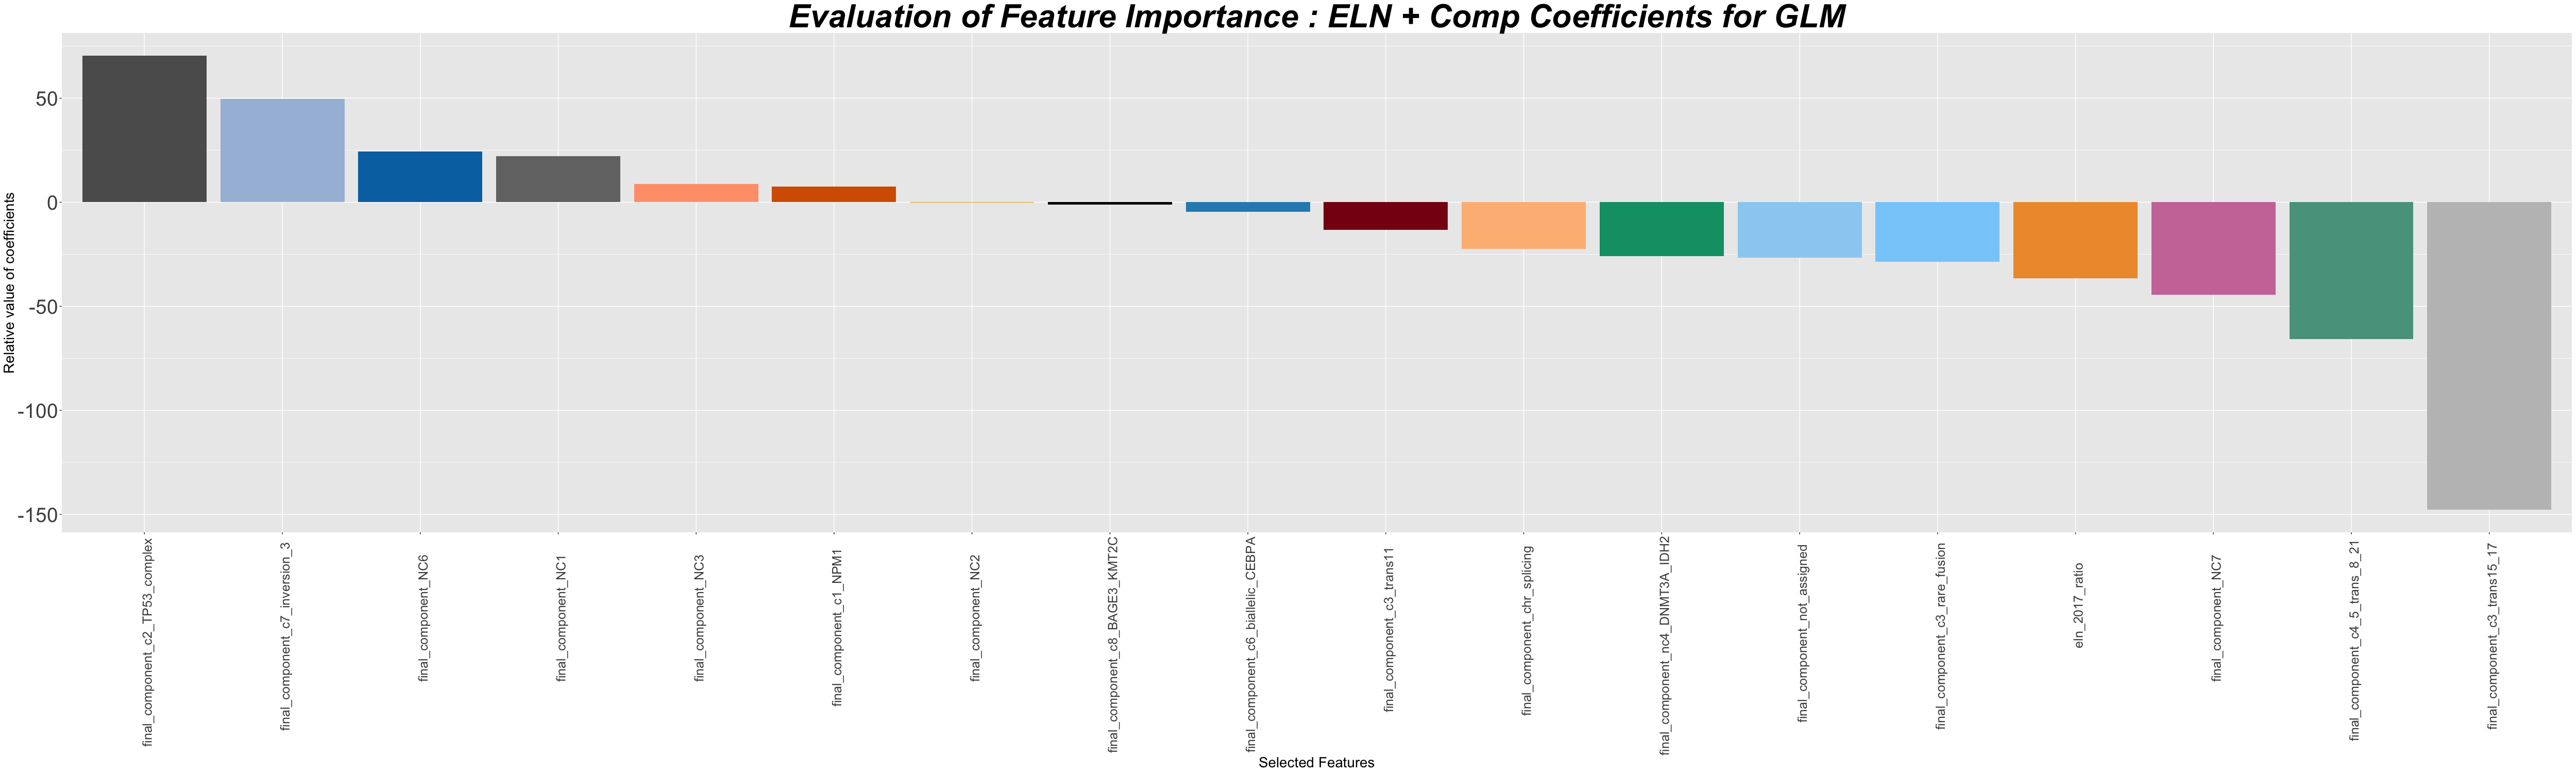

In [61]:
eln_comp_glm <- df_bootstrap[startsWith(df_bootstrap$model_algo,"eln_comp_bootstrap_glm"),]
eln_comp_glm <- eln_comp_glm[,c('feature','sum_coef','num_selected')] %>% group_by(feature) %>% summarize_all(sum)
eln_comp_glm$proportion_coefficients <- eln_comp_glm$sum_coef /3
set_notebook_plot_size(50,15)
ggplot(na.omit(eln_comp_glm),aes(x=reorder(feature,-proportion_coefficients),y=proportion_coefficients))+geom_bar(stat = "identity", aes(fill = reorder(feature,-proportion_coefficients)))+
theme(plot.title = element_text( size=45, face="bold.italic",hjust=0.5),legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8,size=18),axis.text.y=element_text(size=28),axis.title.y = element_text(size = 20),axis.title.x = element_text(size = 20))+xlab("Selected Features") +
ylab("Relative value of coefficients") + ggtitle("Evaluation of Feature Importance : ELN + Comp Coefficients for GLM")+scale_fill_manual(values = cols)